In [ ]:
# Installing necessary packages

#!conda install re --yes
#!conda install nltk --yes
#!conda install openpyxl --yes
#!conda install scikit-learn --yes
#!conda install seaborn --yes
#!pip install lazypredict
#!conda install lightgbm --yes
#!conda install scikit-learn-intelex --yes

In [ ]:
# Importing used libraries

# Warnings - disabled
import warnings
warnings.filterwarnings('ignore')

# Essential packages for data analytics (numpy and pandas)
import numpy as np
import pandas as pd

# Sklearn - feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Import additional sklearn packages
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

# Import all used models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

# Regular expressions
import re

# Spacy
#!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm

#NLTK
import nltk
nltk.download('all')
from nltk import SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk import ngrams
from nltk.collocations import BigramCollocationFinder,BigramAssocMeasures
from nltk.corpus import stopwords
stopwords_ = set(stopwords.words('english'))


#PLOTTING
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors

import seaborn as sn
sn.set_context('notebook') 

from mpl_toolkits import mplot3d

# Display option - Display all columns to be able to explore the data set more
pd.set_option('display.max_columns', None) 

# Real-world data - upload

In [46]:
# Loading the real world data set
real_data = pd.read_csv("Suicide_Detection.csv")
real_data = real_data[["text", "class"]]
real_data["text"].drop_duplicates() # Check if there are repeated posts
real_data["class"].unique() # Check for unique real world data set classes
real_data['class'].replace({'suicide' : 1 , 'non-suicide' : 0}, inplace=True)

# Synthetic data - upload

In [51]:
syn_data_all = pd.read_csv("synthetic_data_all.csv") ##syn_data_all.to_csv('synthetic_data_all.csv', index=False)
syn_data_all = syn_data_1[["Relevant part of the answer", "class"]]

# Data cleaning and preprocessing - functions

In [12]:
# Defining function to clean Reddit posts

def clean_post(post_text):
    
    # Removing links
    post_text = re.sub(r'https?://\S+|www\.\S+', ' ', post_text)
    
    # Removing new line characters (\n)
    post_text = re.sub(r'(\n)', ' ', post_text)

    # Removing tab symbols (\t)
    post_text = re.sub(r'(\t)', ' ', post_text)    

    # Removing email adresses
    post_text = re.sub(r'\S*@\S*', ' ', post_text)

    # Removing user tags
    post_text = re.sub(r'@([A-Za-z0-9_])+', ' ', post_text)
       
    # Removing special characters, emojis, and non-alphabetical characters
    post_text = re.sub(r'[^a-zA-Z\s]', ' ', post_text)
    
    # Splitting words that are incorrectly put together (this can happen if the post has a header)
    post_text = re.sub(r'([a-z])([A-Z])', r'\1 \2', post_text)    
    
    # Substituting !?.:; with a white space (this allows to avoid header and post being put together)
    post_text = re.sub(r'[!?.:;]', ' ', post_text)
    
    # Substituting multiple white spaces with a single space
    post_text = re.sub(r'\s+', ' ', post_text)
    
    # Removing white spaces at the end
    post_text = re.sub(r'\s+$', '', post_text)
    
    # Converting text to lowercase
    post_text = post_text.lower()
    
    return post_text

In [ ]:
# Defining a function to tokenize text

def tokenize_text(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc])

# Defining a function to lemmatize text

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

# Defining a function for text stemming

def stem_text(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return " ".join(stemmed_words)

# Defining a function for generating bigrams

def generate_bigrams(text, n=2):
    tokens = nltk.word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return [' '.join(gram) for gram in n_grams]

# Defining a function for generating trigrams

def generate_trigrams(text, n=3):
    tokens = nltk.word_tokenize(text)
    n_grams = list(ngrams(tokens, n))
    return [' '.join(gram) for gram in n_grams]

# Defining a function for extracting POS (part of speech) --> only returns tags not the token&tag combination

def pos_tagger(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    return pos_tags

# Defining a function for excluding stopwords and only including pre-deteremined POS

def no_stopwords(text):
    doc = nlp(text)
    selected_tokens = [token.text for token in doc
                       if token.pos_ in {'NOUN', 'VERB', 'PROPN', 'ADJ', 'ADV'}
                       and not token.is_stop]
    return " ".join(selected_tokens)

# Generate a sorted dictionary of n most common collocations 
def top_n_collocations(documents, n):
    # Initialize an empty list to store collocations
    collocations = []

    for document in documents:
        # Check if the document is not NaN or None
        if pd.notna(document):
            words = [word.lower() for word in document.split() if len(word) > 2 and word not in stopwords_]
            finder = BigramCollocationFinder.from_words(words)
            bgm = BigramAssocMeasures()
            collocations.extend(finder.score_ngrams(bgm.mi_like))

    # Sort and return the top n collocations
    top_collocations = sorted(collocations, key=lambda x: x[1], reverse=True)[:n]

    return top_collocations

def substitute_collocations(text, top_collocations):
    if pd.notna(text):  # Check if the text is not NaN
        # Replace collocations in the text
        for bigram, _ in top_collocations:
            collocation = "_".join(bigram)
            text = text.replace(" ".join(bigram), collocation)
    return text

# Data cleaning and preprocessing - execution

In [ ]:
# Takes 2/3h to execute

# Applying the reg ex cleaning functions to the 'text' column
real_data["clean_text"] = real_data["text"].apply(lambda x: clean_post(x))

# Applying the tokenize_text function to the 'clean_text' column
real_data['tokens'] = real_data['clean_text'].apply(tokenize_text)

# Applying the lemmatize_text function to the 'clean_text' column
real_data['lemmatized_text'] = real_data['clean_text'].apply(lemmatize_text)

# Applying the no_stopwords function to the 'lemmatized_text' column
real_data['no_stopwords'] = real_data['lemmatized_text'].apply(no_stopwords)


# Applying the pos_tagger function from the 'no_stopwords' and 'clean_text' columns
real_data['pos_tags_limited'] = real_data['no_stopwords'].apply(pos_tagger)
real_data['pos_tags_all'] = real_data['clean_text'].apply(pos_tagger)

#real_data

In [ ]:
real_suicide_messages = real_data[real_data["class"]==1]
real_nonsuicide_messages = real_data[real_data["class"]==0]

# Generate and replace 50 most common collocations - real suicide data 
top_50_collocations_suicide_real = top_n_collocations(real_suicide_messages['no_stopwords'], 50)
real_suicide_messages['collocated_text'] = real_suicide_messages['no_stopwords'].apply(lambda x: substitute_collocations(x, top_50_collocations_suicide_real))

# Generate and replace 50 most common collocations - real non-suicide data
top_50_collocations_nonsuicide_real = top_n_collocations(real_nonsuicide_messages['no_stopwords'], 50)
real_nonsuicide_messages['collocated_text'] = real_nonsuicide_messages['no_stopwords'].apply(lambda x: substitute_collocations(x, top_50_collocations_nonsuicide_real))

real_data = pd.concat([real_suicide_messages, real_nonsuicide_messages])
real_data.reset_index(inplace=True, drop=True)

In [ ]:
# Takes 15-20min to execute

# Applying the reg ex cleaning functions to the 'text' column
syn_data_all["clean_text"] = syn_data_all["Relevant part of the answer"].apply(lambda x: clean_post(x))

# Applying the tokenize_text function to the 'clean_text' column
syn_data_all['tokens'] = syn_data_all['clean_text'].apply(tokenize_text)

# Applying the lemmatize_text function to the 'clean_text' column
syn_data_all['lemmatized_text'] = syn_data_all['clean_text'].apply(lemmatize_text)

# Applying the no_stopwords function to the 'lemmatized_text' column
syn_data_all['no_stopwords'] = syn_data_all['lemmatized_text'].apply(no_stopwords)

# Applying the pos_tagger function from the 'no_stopwords' and 'clean_text' columns
syn_data_all['pos_tags_limited'] = syn_data_all['no_stopwords'].apply(pos_tagger)
syn_data_all['pos_tags_all'] = syn_data_all['clean_text'].apply(pos_tagger)

#syn_data_all

In [ ]:
syn_data_all.rename(columns={'Relevant part of the answer': 'text'}, inplace=True)
syn_data_all['class'].replace({'suicide' : 1 , 'non-suicide' : 0}, inplace=True)

syn_data_all_suicide = syn_data_all[syn_data_all["class"] == 1]
syn_data_all_nonsuicide = syn_data_all[syn_data_all["class"] == 0]

top_50_collocations_suicide_real = top_n_collocations(syn_data_all_suicide['no_stopwords'], 50)
syn_data_all_suicide['collocated_text'] = syn_data_all_suicide['no_stopwords'].apply(lambda x: substitute_collocations(x, top_50_collocations_suicide_real))

top_50_collocations_nonsuicide_real = top_n_collocations(syn_data_all_nonsuicide['no_stopwords'], 50)
syn_data_all_nonsuicide['collocated_text'] = syn_data_all_nonsuicide['no_stopwords'].apply(lambda x: substitute_collocations(x, top_50_collocations_nonsuicide_real))

syn_data_all = pd.concat([syn_data_all_suicide, syn_data_all_nonsuicide])
syn_data_all.reset_index(inplace=True, drop=True)

# Upload preprocessed data (to avoid long preprocessing steps)

In [ ]:
real_data = pd.read_csv('ready_for_model_preprocessed_real_data.csv')
real_data = real_data.sample(frac=1).reset_index(drop=True)
syn_data = pd.read_csv('preprocessed_synthetic_data_all.csv')

# TFIDF

In [5]:
real_suicide_messages = real_data[real_data["class"] == 1]
real_nonsuicide_messages = real_data[real_data["class"] == 0]
syn_suicide_messages = syn_data[syn_data["class"] == 1]
syn_nonsuicide_messages = syn_data[syn_data["class"] == 0]

                  word     tf       idf        tfidf
2927          life don   3128  4.667041   451.579680
3790         past year   3448  4.606515   460.885999
5124        think kill   2754  4.802260   477.334534
5180     think suicide   3027  4.714702   484.208610
5699         want feel   3325  4.653307   491.500542
2673         know feel   3464  4.582055   495.255097
5497          try kill   3207  4.696822   507.184505
5797         want talk   2895  4.798791   508.196225
1765     friend family   3505  4.566074   522.739503
3535         month ago   4040  4.430563   526.253902
3615         need talk   2035  5.155081   534.510910
2629      know anymore   3508  4.582675   543.831168
4344         self harm   3766  4.612885   576.667248
3455     mental health   4188  4.514674   579.779876
1627          feel way   4383  4.390892   589.933755
3209         long time   4704  4.290894   614.602494
2320       high school   6393  4.172468   651.362775
1419          feel bad   5263  4.226992   672.

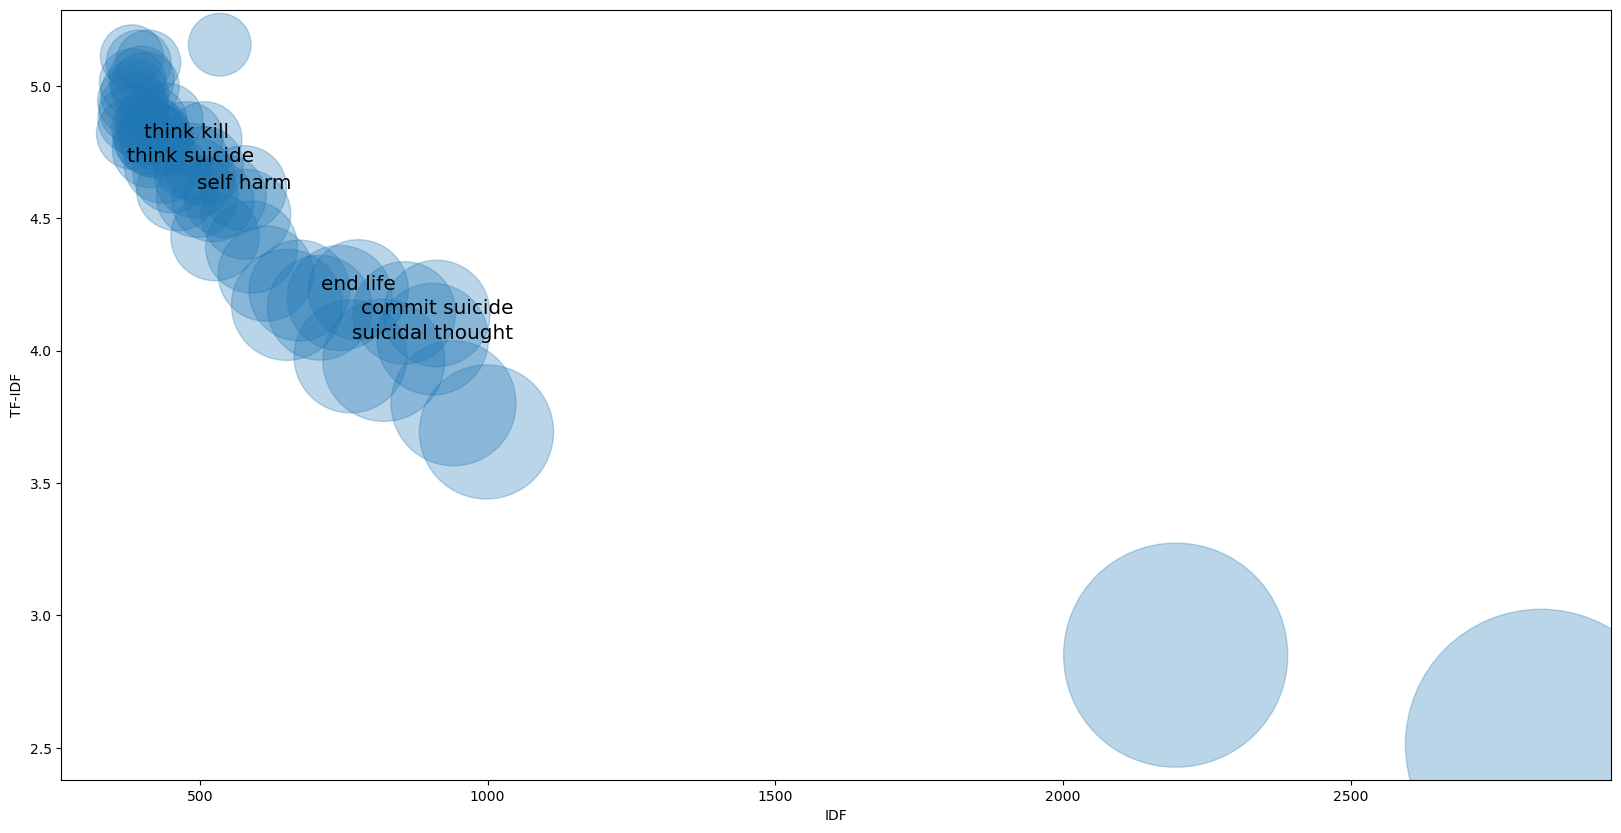

In [6]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                    min_df=0.001, 
                                    max_df=0.75, 
                                    stop_words=None,
                                    ngram_range = (2,2),
                                    sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(real_suicide_messages['collocated_text'].values.astype('U'))

vectorizer = CountVectorizer(analyzer='word', 
                              min_df=0.001, 
                              max_df=0.75, 
                              stop_words=None,
                              ngram_range = (2,2))

X2 = vectorizer.fit_transform(real_suicide_messages['collocated_text'].values.astype('U'))

tfidf = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                    }).sort_values(['tfidf', 'tf', 'idf']) # sort by TFIDF, then TF, then IDF

print(tfidf[-30:])

words_to_plot = tfidf.iloc[-30:].reset_index(drop=True)
words_to_plot
l = [2,3,12,21,24,25]

fig = plt.figure(figsize = (20,10))
plt.scatter(x=tfidf.tfidf[-50:], y=tfidf.idf[-50:], s=tfidf.tf[-50:], alpha=0.3,c = 'tab:blue',cmap='viridis')

for i in l:
    plt.text(x=words_to_plot.tfidf.iloc[i], y=words_to_plot.idf.iloc[i], s=words_to_plot.word.iloc[i], fontsize='x-large', ha='center')

plt.xlabel("IDF")
plt.ylabel("TF-IDF")

plt.show()

               word    tf       idf        tfidf
353       month ago   638  6.249855   301.864835
307        let know   611  6.298645   303.838834
104     fall asleep   524  6.541376   308.099321
116       feel free   562  6.366407   316.099978
578         tik tok   650  6.595565   316.465689
619      wanna talk   486  6.536990   316.695820
345   mental health   732  6.263078   318.682882
62        didn know   775  6.113454   333.128439
380   online school   659  6.368254   335.352738
325       long time   730  6.139580   339.623094
43          day day  1728  6.324847   345.074699
117       feel good   689  6.212784   356.574913
668       wish luck   501  6.485806   371.885374
416       play game   836  6.046947   374.985462
189        good day   845  6.158883   382.565595
95        don wanna   781  6.113454   413.675398
612      video game   908  5.994716   420.463097
111        feel bad   987  5.898943   426.148951
637       want know   881  5.934241   445.491958
65   discord server 

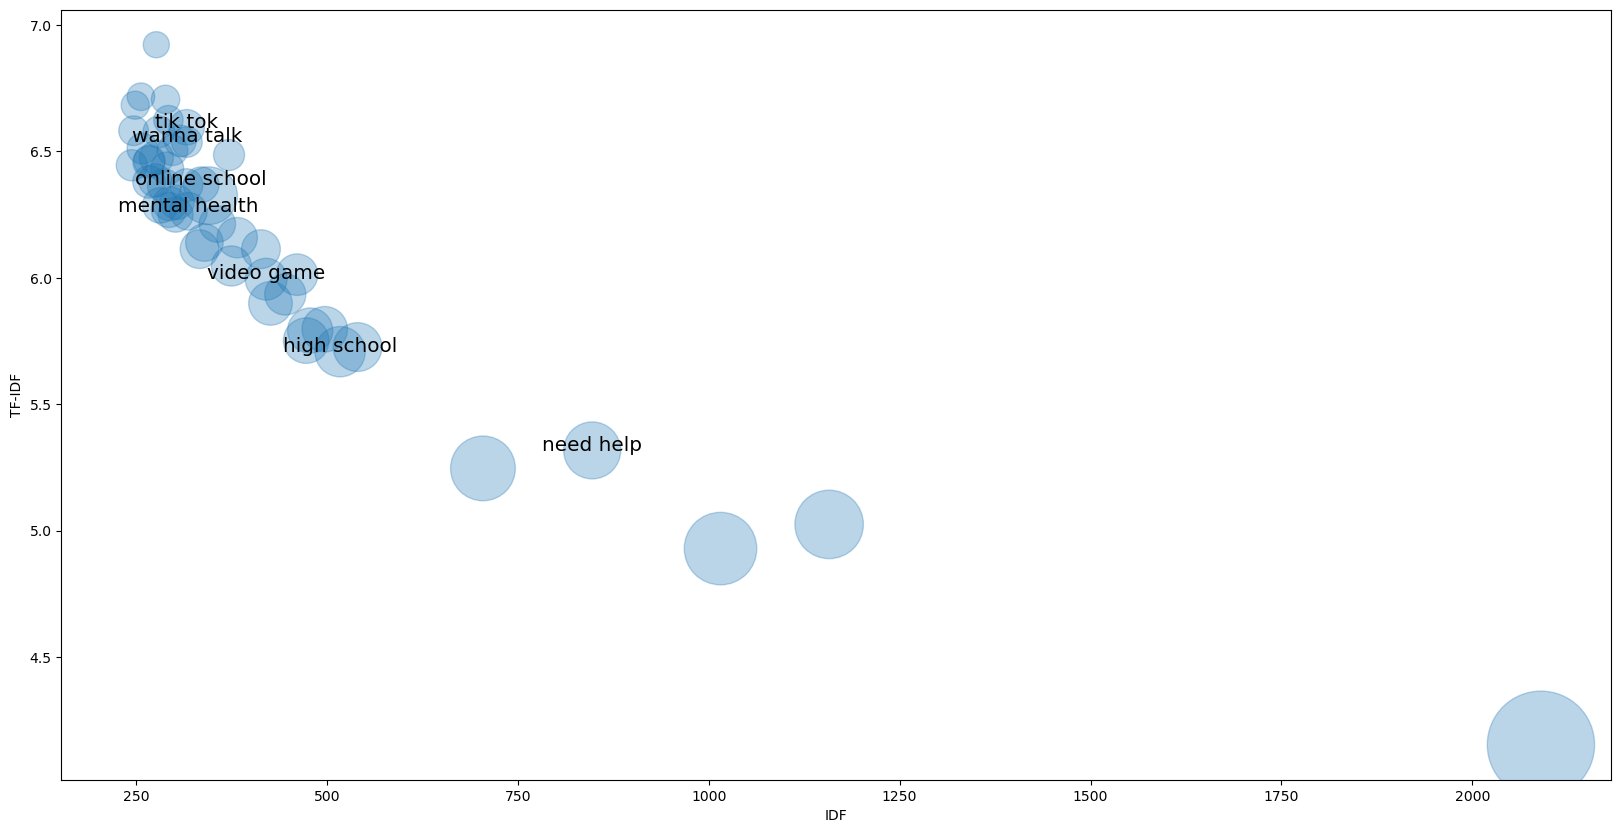

In [7]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                    min_df=0.001, 
                                    max_df=0.75, 
                                    stop_words=None,
                                    ngram_range = (2,2),
                                    sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(real_nonsuicide_messages['collocated_text'].values.astype('U'))

vectorizer = CountVectorizer(analyzer='word', 
                              min_df=0.001, 
                              max_df=0.75, 
                              stop_words=None,
                              ngram_range = (2,2))

X2 = vectorizer.fit_transform(real_nonsuicide_messages['collocated_text'].values.astype('U'))

tfidf = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                    }).sort_values(['tfidf', 'tf', 'idf']) # sort by TFIDF, then TF, then IDF

print(tfidf[-30:])

words_to_plot = tfidf.iloc[-30:].reset_index(drop=True)
words_to_plot
l = [4,5,6,8,16,23,26]

fig = plt.figure(figsize = (20,10))
plt.scatter(x=tfidf.tfidf[-50:], y=tfidf.idf[-50:], s=tfidf.tf[-50:], alpha=0.3,c = 'tab:blue',cmap='viridis')

for i in l:
    plt.text(x=words_to_plot.tfidf.iloc[i], y=words_to_plot.idf.iloc[i], s=words_to_plot.word.iloc[i], fontsize='x-large', ha='center')

    
plt.xlabel("IDF")
plt.ylabel("TF-IDF")

plt.show()

                      word   tf       idf      tfidf
376            find solace   36  6.311874  21.107922
1018             true self   37  6.311874  21.159333
175          depth despair   43  6.138602  21.392088
949              stuck end   37  6.285205  21.408148
672       negative thought   32  6.426284  21.836989
318             feel heavy   49  6.010769  22.033628
361               find joy   45  6.094150  22.476172
1118            way escape   49  6.010769  23.463512
1141        weight sadness   47  6.051591  23.481715
399           glimmer hope   49  6.010769  23.657031
1023              try find   46  6.072644  23.764519
436            heavy heart   51  5.971548  24.628531
1109            watch life   39  6.233912  25.265975
1010              trap end   53  5.933808  25.616869
666              need help   56  5.879740  26.500559
640               miss day   46  6.072644  27.154342
851         self criticism   44  6.116129  27.602769
763           puzzle piece   47  6.051591  29.

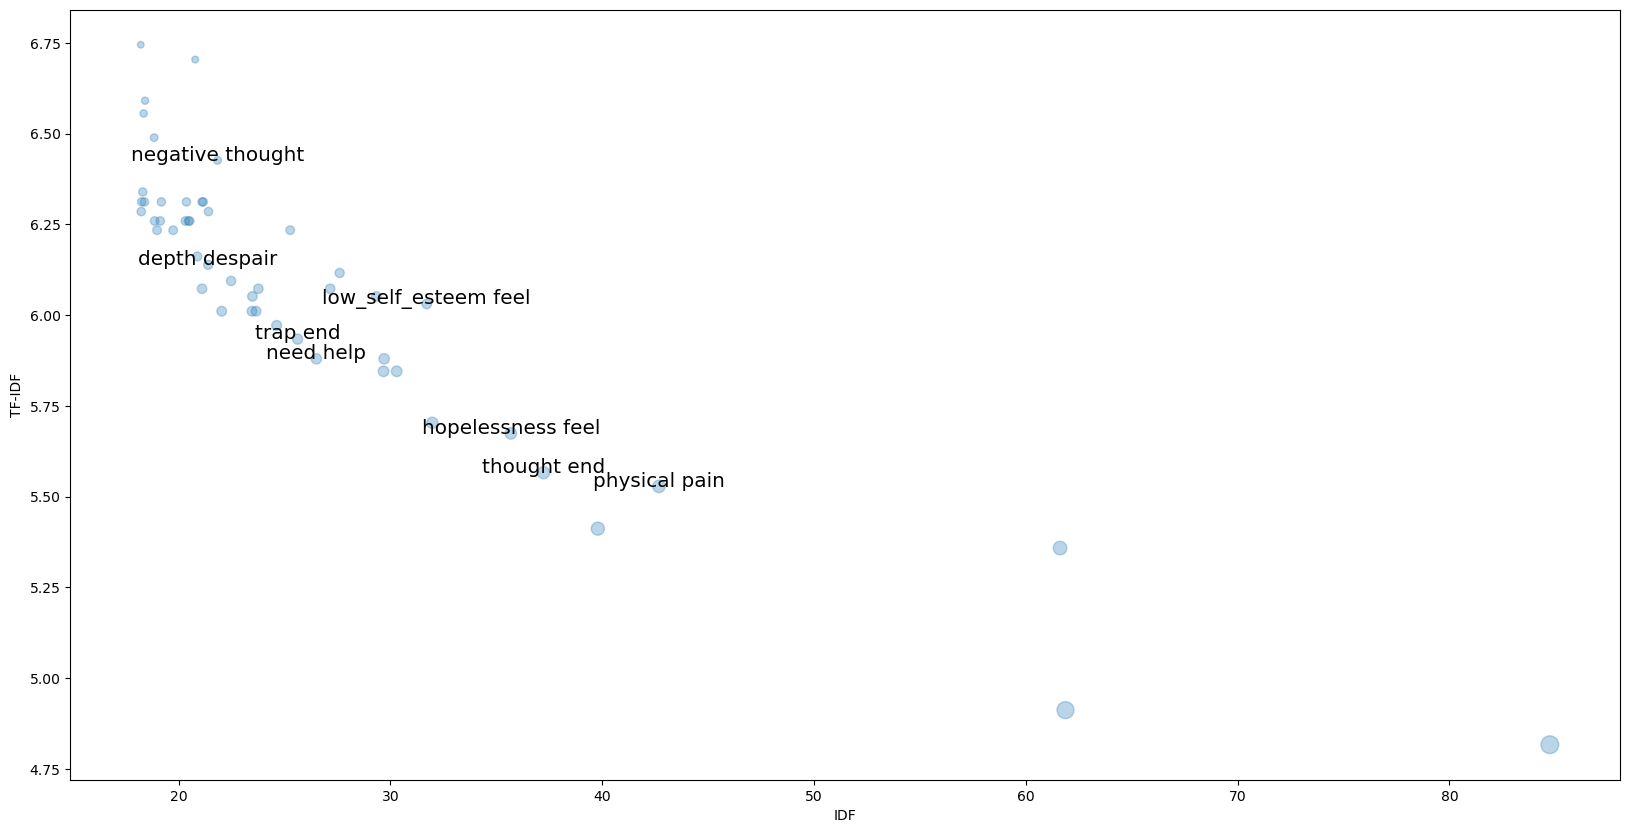

In [8]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                    min_df=0.001, 
                                    max_df=0.75, 
                                    stop_words=None,
                                    ngram_range = (2,2),
                                    sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(syn_suicide_messages['collocated_text'].values.astype('U'))

vectorizer = CountVectorizer(analyzer='word', 
                              min_df=0.001, 
                              max_df=0.75, 
                              stop_words=None,
                              ngram_range = (2,2))

X2 = vectorizer.fit_transform(syn_suicide_messages['collocated_text'].values.astype('U'))

tfidf = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                    }).sort_values(['tfidf', 'tf', 'idf']) # sort by TFIDF, then TF, then IDF

print(tfidf[-30:])

words_to_plot = tfidf.iloc[-30:].reset_index(drop=True)
words_to_plot
l = [2,4,13,14,21,23,24,26]

fig = plt.figure(figsize = (20,10))
plt.scatter(x=tfidf.tfidf[-50:], y=tfidf.idf[-50:], s=tfidf.tf[-50:], alpha=0.3,c = 'tab:blue',cmap='viridis')

for i in l:
    plt.text(x=words_to_plot.tfidf.iloc[i], y=words_to_plot.idf.iloc[i], s=words_to_plot.word.iloc[i], fontsize='x-large', ha='center')

plt.xlabel("IDF")
plt.ylabel("TF-IDF")

plt.show()

                        word  tf       idf      tfidf
269       start tube_channel  20  6.878269  16.773994
38   competitive underground  22  6.787297  17.023569
107              fellow teen  19  6.927059  17.182205
237                share diy  22  6.787297  17.217456
293                 time job  24  6.744738  17.223443
266                start new  24  6.703916  17.428927
4        amateur competitive  19  6.927059  17.651107
249            share thought  21  6.831749  17.711554
159                let share  23  6.744738  17.878396
117            friend family  22  6.831749  18.028542
201          positive impact  21  6.831749  18.538492
173               master art  22  6.831749  18.732502
270              stay active  24  6.703916  19.101023
272           stay motivated  22  6.787297  19.340616
305                tv series  22  6.831749  20.041268
34       college application  27  6.590587  20.282332
287           teen volunteer  24  6.703916  21.422586
59         different culture

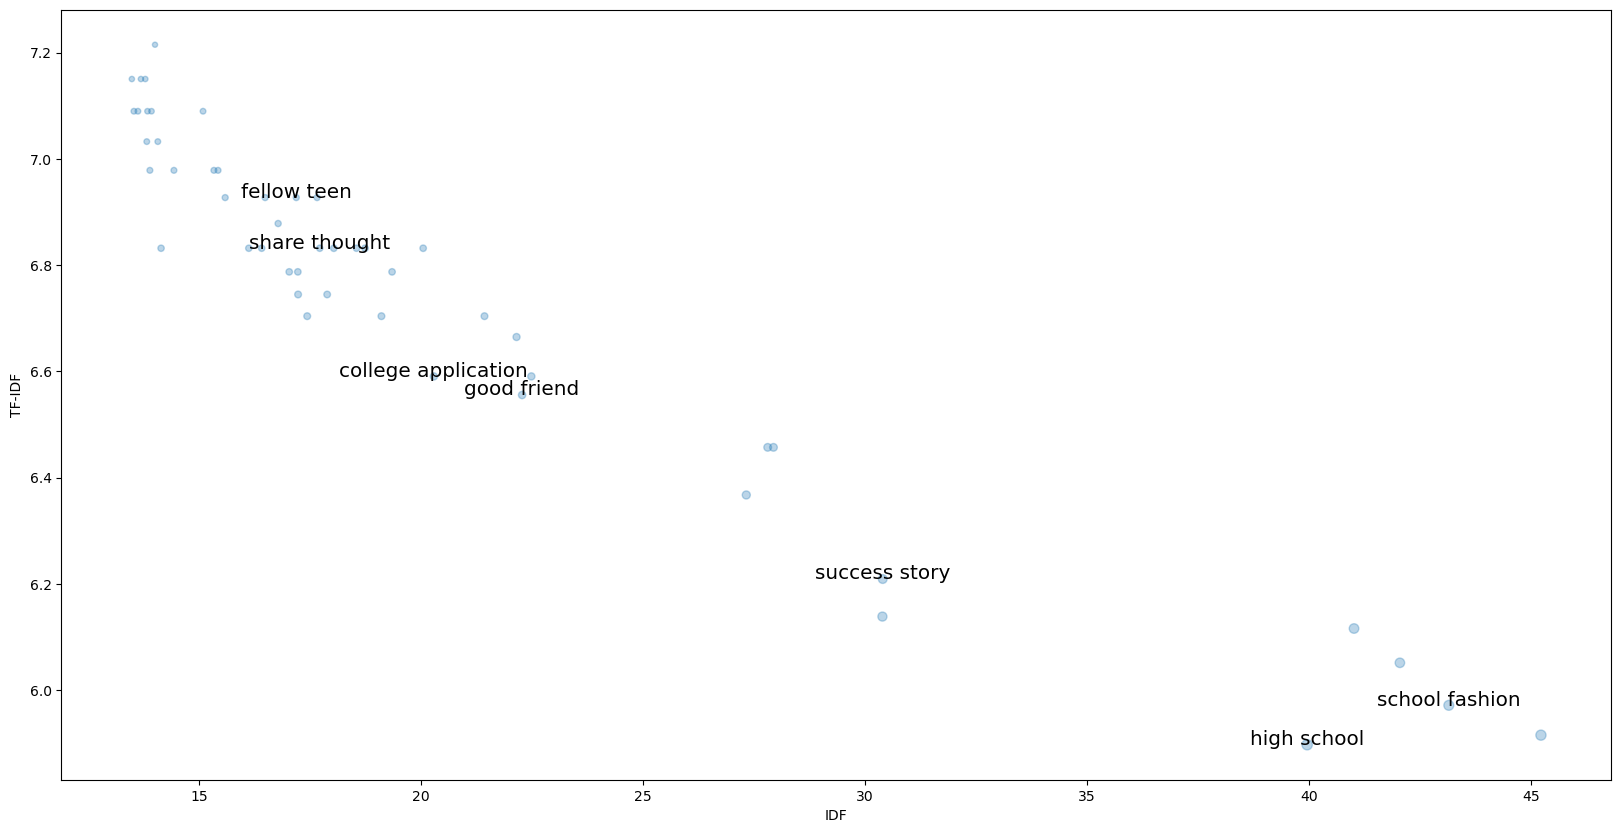

In [9]:
# TFIDF
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                    min_df=0.001, 
                                    max_df=0.75, 
                                    stop_words=None,
                                    ngram_range = (2,2),
                                    sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(syn_nonsuicide_messages['collocated_text'].values.astype('U'))

vectorizer = CountVectorizer(analyzer='word', 
                              min_df=0.001, 
                              max_df=0.75, 
                              stop_words=None,
                              ngram_range = (2,2))

X2 = vectorizer.fit_transform(syn_nonsuicide_messages['collocated_text'].values.astype('U'))

tfidf = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                    }).sort_values(['tfidf', 'tf', 'idf']) # sort by TFIDF, then TF, then IDF

print(tfidf[-30:])

words_to_plot = tfidf.iloc[-30:].reset_index(drop=True)
words_to_plot
l = [2,7,15,18,24,25,28]

fig = plt.figure(figsize = (20,10))
plt.scatter(x=tfidf.tfidf[-50:], y=tfidf.idf[-50:], s=tfidf.tf[-50:], alpha=0.3,c = 'tab:blue',cmap='viridis')

for i in l:
    plt.text(x=words_to_plot.tfidf.iloc[i], y=words_to_plot.idf.iloc[i], s=words_to_plot.word.iloc[i], fontsize='x-large', ha='center')

plt.xlabel("IDF")
plt.ylabel("TF-IDF")

plt.show()

# Descriptive statistics - length of posts

In [37]:
# Function to calculate the number of words in a text
def count_words(text):
    if pd.notna(text):
        # Split the text into words using whitespace as a separator
        words = text.split()
        # Return the number of words
        return len(words)
    return 0  # Return 0 for missing values

# Apply the function to the DataFrame column
real_data['WordCount'] = real_data['text'].apply(count_words)
syn_data['WordCount'] = syn_data['text'].apply(count_words)
real_data['WordCountClean'] = real_data['collocated_text'].apply(count_words)
syn_data['WordCountClean'] = syn_data['collocated_text'].apply(count_words)

# Calculate the average word count
print("Average suicide-real orignial: " + str(real_data[real_data["class"] == 1]['WordCount'].mean()))
print("Average suicide-real clean: " + str(real_data[real_data["class"] == 1]['WordCountClean'].mean()))

# Calculate the average word count
print("Average nonsuicide-real orignial: " + str(real_data[real_data["class"] == 0]['WordCount'].mean()))
print("Average nonsuicide-real clean: " + str(real_data[real_data["class"] == 0]['WordCountClean'].mean()))

# Calculate the average word count
print("Average suicide-synthetic orignial: " + str(syn_data[syn_data["class"] == 1]['WordCount'].mean()))
print("Average suicide-synthetic clean: " + str(syn_data[syn_data["class"] == 1]['WordCountClean'].mean()))

# Calculate the average word count
print("Average nonsuicide-synthetic orignial: " + str(syn_data[syn_data["class"] == 0]['WordCount'].mean()))
print("Average nonsuicide-synthetic clean: " + str(syn_data[syn_data["class"] == 0]['WordCountClean'].mean()))

Average suicide-real orignial: 202.66216810155382
Average suicide-real clean: 76.05472392426553
Average nonsuicide-real orignial: 61.188302007118416
Average nonsuicide-real clean: 24.125322095538493
Average suicide-synthetic orignial: 25.752533333333332
Average suicide-synthetic clean: 11.244266666666666
Average nonsuicide-synthetic orignial: 16.252133333333333
Average nonsuicide-synthetic clean: 9.3932


# Models

# Approach 1

In [5]:
# Shuffle the real-world dataset before conducting the splits
real_data = shuffle(real_data, random_state=16)

# TRAIN SET
## Case 1 (only 5k of real-world data available for training)
### Option 1
X_train11 = real_data['collocated_text'][0:5000]
y_train11 = real_data['class'][0:5000]

### Option 2
syn_X_train12 = syn_data['collocated_text']
syn_y_train12 = syn_data['class']
real_X_train12 = real_data['collocated_text'][0:5000]
real_y_train12 = real_data['class'][0:5000]

X_train12 = pd.concat([syn_X_train12, real_X_train12])
y_train12 = pd.concat([syn_y_train12, real_y_train12])

### Option 3
X_train13 = syn_data['collocated_text']
y_train13 = syn_data['class']

## Case 2 (only 15k of real-world data available for training)
### Option 1
X_train21 = real_data['collocated_text'][0:15000]
y_train21 = real_data['class'][0:15000]

### Option 2
syn_X_train22 = syn_data['collocated_text']
syn_y_train22 = syn_data['class']
real_X_train22 = real_data['collocated_text'][0:15000]
real_y_train22 = real_data['class'][0:15000]

X_train22 = pd.concat([syn_X_train22, real_X_train22])
y_train22 = pd.concat([syn_y_train22, real_y_train22])

### Option 3
X_train23 = syn_data['collocated_text']
y_train23 = syn_data['class']


## Case 3 (only 45k of real-world data available for training)
### Option 1
X_train31 = real_data['collocated_text'][0:45000]
y_train31 = real_data['class'][0:45000]

### Option 2
syn_X_train32 = syn_data['collocated_text']
syn_y_train32 = syn_data['class']
real_X_train32 = real_data['collocated_text'][0:45000]
real_y_train32 = real_data['class'][0:45000]

X_train32 = pd.concat([syn_X_train32, real_X_train32])
y_train32 = pd.concat([syn_y_train32, real_y_train32])

### Option 3
X_train33 = syn_data['collocated_text']
y_train33 = syn_data['class']

## Case 4 (full real-world dataset available for training, except for validation and testing portion - 157,952)
### Option 1
X_train41 = real_data['collocated_text'][0:157952]
y_train41 = real_data['class'][0:157952]

### Option 2
syn_X_train42 = syn_data['collocated_text']
syn_y_train42 = syn_data['class']
real_X_train42 = real_data['collocated_text'][0:157952]
real_y_train42 = real_data['class'][0:157952]

X_train42 = pd.concat([syn_X_train42, real_X_train42])
y_train42 = pd.concat([syn_y_train42, real_y_train42])

### Option 3
X_train43 = syn_data['collocated_text']
y_train43 = syn_data['class']

#---------------------------------------------------------------------------------------

# VAL SET
## Case 1 (only 5k of real-world data available for training)
### Option 1
X_val11 = real_data['collocated_text'][223502:227788]
y_val11 = real_data['class'][223502:227788]

### Option 2
X_val12 = real_data['collocated_text'][223502:227788]
y_val12 = real_data['class'][223502:227788]

### Option 3
X_val13 = real_data['collocated_text'][223502:227788]
y_val13 = real_data['class'][223502:227788]

## Case 2 (only 15k of real-world data available for training)
### Option 1
X_val21 = real_data['collocated_text'][219217:225645]
y_val21 = real_data['class'][219217:225645]

### Option 2
X_val22 = real_data['collocated_text'][219217:225645]
y_val22 = real_data['class'][219217:225645]

### Option 3
X_val23 = real_data['collocated_text'][219217:225645]
y_val23 = real_data['class'][219217:225645]

## Case 3 (only 45k of real-world data available for training)
### Option 1
X_val31 = real_data['collocated_text'][206360:219217]
y_val31 = real_data['class'][206360:219217]

### Option 2
X_val32 = real_data['collocated_text'][206360:219217]
y_val32 = real_data['class'][206360:219217]

### Option 3
X_val33 = real_data['collocated_text'][206360:219217]
y_val33 = real_data['class'][206360:219217]

##Case 4 (full real-world dataset available for training, except for validation and testing portion - 157,952)
### Option 1
X_val41 = real_data['collocated_text'][157952:195013]
y_val41 = real_data['class'][157952:195013]

### Option 2
X_val42 = real_data['collocated_text'][157952:195013]
y_val42 = real_data['class'][157952:195013]

### Option 3
X_val43 = real_data['collocated_text'][157952:195013]
y_val43 = real_data['class'][157952:195013]


#---------------------------------------------------------------------------------------

# TEST SET
## Case 1 (only 5k of real-world data available for training)
### Option 1
X_test11 = real_data['collocated_text'][227788:]
y_test11 = real_data['class'][227788:]

### Option 2
X_test12 = real_data['collocated_text'][227788:]
y_test12 = real_data['class'][227788:]

### Option 3
X_test13 = real_data['collocated_text'][227788:]
y_test13 = real_data['class'][227788:]

## Case 2 (only 15k of real-world data available for training)
### Option 1
X_test21 = real_data['collocated_text'][225645:]
y_test21 = real_data['class'][225645:]

### Option 2
X_test22 = real_data['collocated_text'][225645:]
y_test22 = real_data['class'][225645:]

### Option 3
X_test23 = real_data['collocated_text'][225645:]
y_test23 = real_data['class'][225645:]

## Case 3 (only 45k of real-world data available for training)
### Option 1
X_test31 = real_data['collocated_text'][219217:]
y_test31 = real_data['class'][219217:]

### Option 2
X_test32 = real_data['collocated_text'][219217:]
y_test32 = real_data['class'][219217:]

### Option 3
X_test33 = real_data['collocated_text'][219217:]
y_test33 = real_data['class'][219217:]

##Case 4 (full real-world dataset available for training, except for validation and testing portion - 157,952)
### Option 1
X_test41 = real_data['collocated_text'][195013:]
y_test41 = real_data['class'][195013:]

### Option 2
X_test42 = real_data['collocated_text'][195013:]
y_test42 = real_data['class'][195013:]

### Option 3
X_test43 = real_data['collocated_text'][195013:]
y_test43 = real_data['class'][195013:]

In [6]:
# Vectorize your text data using TF-IDF
vectorizer_tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=0.001,
    max_df=0.75,
    stop_words='english')

In [7]:
# Case 1
vtf_X_train11 = vectorizer_tfidf.fit_transform(X_train11.values.astype('U'))
vtf_X_val11 = vectorizer_tfidf.transform(X_val11.values.astype('U'))
vtf_X_test11 = vectorizer_tfidf.transform(X_test11.values.astype('U'))

vtf_X_train12 = vectorizer_tfidf.fit_transform(X_train12.values.astype('U'))
vtf_X_val12 = vectorizer_tfidf.transform(X_val12.values.astype('U'))
vtf_X_test12 = vectorizer_tfidf.transform(X_test12.values.astype('U'))

vtf_X_train13 = vectorizer_tfidf.fit_transform(X_train13.values.astype('U'))
vtf_X_val13 = vectorizer_tfidf.transform(X_val13.values.astype('U'))
vtf_X_test13 = vectorizer_tfidf.transform(X_test13.values.astype('U'))

# Case 2
vtf_X_train21 = vectorizer_tfidf.fit_transform(X_train21.values.astype('U'))
vtf_X_val21 = vectorizer_tfidf.transform(X_val21.values.astype('U'))
vtf_X_test21 = vectorizer_tfidf.transform(X_test21.values.astype('U'))

vtf_X_train22 = vectorizer_tfidf.fit_transform(X_train22.values.astype('U'))
vtf_X_val22 = vectorizer_tfidf.transform(X_val22.values.astype('U'))
vtf_X_test22 = vectorizer_tfidf.transform(X_test22.values.astype('U'))

vtf_X_train23 = vectorizer_tfidf.fit_transform(X_train23.values.astype('U'))
vtf_X_val23 = vectorizer_tfidf.transform(X_val23.values.astype('U'))
vtf_X_test23 = vectorizer_tfidf.transform(X_test23.values.astype('U'))

# Case 3
vtf_X_train31 = vectorizer_tfidf.fit_transform(X_train31.values.astype('U'))
vtf_X_val31 = vectorizer_tfidf.transform(X_val31.values.astype('U'))
vtf_X_test31 = vectorizer_tfidf.transform(X_test31.values.astype('U'))

vtf_X_train32 = vectorizer_tfidf.fit_transform(X_train32.values.astype('U'))
vtf_X_val32 = vectorizer_tfidf.transform(X_val32.values.astype('U'))
vtf_X_test32 = vectorizer_tfidf.transform(X_test32.values.astype('U'))

vtf_X_train33 = vectorizer_tfidf.fit_transform(X_train33.values.astype('U'))
vtf_X_val33 = vectorizer_tfidf.transform(X_val33.values.astype('U'))
vtf_X_test33 = vectorizer_tfidf.transform(X_test33.values.astype('U'))

# Case 4
vtf_X_train41 = vectorizer_tfidf.fit_transform(X_train41.values.astype('U'))
vtf_X_val41 = vectorizer_tfidf.transform(X_val41.values.astype('U'))
vtf_X_test41 = vectorizer_tfidf.transform(X_test41.values.astype('U'))

vtf_X_train42 = vectorizer_tfidf.fit_transform(X_train42.values.astype('U'))
vtf_X_val42 = vectorizer_tfidf.transform(X_val42.values.astype('U'))
vtf_X_test42 = vectorizer_tfidf.transform(X_test42.values.astype('U'))

vtf_X_train43 = vectorizer_tfidf.fit_transform(X_train43.values.astype('U'))
vtf_X_val43 = vectorizer_tfidf.transform(X_val43.values.astype('U'))
vtf_X_test43 = vectorizer_tfidf.transform(X_test43.values.astype('U'))

# Hyperparameter tuning

In [133]:
def tune_logistic_regression(params, train_data, val_data):
    best_c = None
    best_accuracy = 0
    acc_saved = []
    
    for c_value in params:
        lr_model = LogisticRegression(C=c_value)
        lr_model.fit(train_data[0], train_data[1])
        
        y_pred = lr_model.predict(val_data[0])
        accuracy = (y_pred == val_data[1]).mean()
        acc_saved.append(accuracy)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_c = c_value
    
    return best_c, acc_saved

# Define hyperparameters and data for different cases and options
param_values = [0.01, 0.1, 1, 10]

# Define a list of cases and options
cases_and_options = [
    (vtf_X_train11, y_train11, vtf_X_val11, y_val11),
    (vtf_X_train12, y_train12, vtf_X_val12, y_val12),
    (vtf_X_train13, y_train13, vtf_X_val13, y_val13),
    (vtf_X_train21, y_train21, vtf_X_val21, y_val21),
    (vtf_X_train22, y_train22, vtf_X_val22, y_val22),
    (vtf_X_train23, y_train23, vtf_X_val23, y_val23),
    (vtf_X_train31, y_train31, vtf_X_val31, y_val31),
    (vtf_X_train32, y_train32, vtf_X_val32, y_val32),
    (vtf_X_train33, y_train33, vtf_X_val33, y_val33),
    (vtf_X_train41, y_train41, vtf_X_val41, y_val41),
    (vtf_X_train42, y_train42, vtf_X_val42, y_val42),
    (vtf_X_train43, y_train43, vtf_X_val43, y_val43)
]

# Iterate over groups of 4 cases and options
for case_idx in range(0, len(cases_and_options), 3):
    case = cases_and_options[case_idx:case_idx + 3]
    
    for i, data in enumerate(case):
        best_c, acc_saved = tune_logistic_regression(param_values, data, data[2:])
        
        print(f"Case {case_idx // 3 + 1}, Option {i % 3 + 1} - Best C: {best_c}")
        print(f"Case {case_idx // 3 + 1}, Option {i % 3 + 1} - Validation Accuracies: {acc_saved}")

Case 1, Option 1 - Best C: 10
Case 1, Option 1 - Validation Accuracies: [0.8478768082127858, 0.880774615025665, 0.9027064862342511, 0.9078394773681755]
Case 1, Option 2 - Best C: 10
Case 1, Option 2 - Validation Accuracies: [0.850443303779748, 0.8693420438637424, 0.8831077928138125, 0.8887074195053664]
Case 1, Option 3 - Best C: 0.01
Case 1, Option 3 - Validation Accuracies: [0.7638824078394774, 0.7580494633691087, 0.7454503033131125, 0.7391507232851143]
Case 2, Option 1 - Best C: 10
Case 2, Option 1 - Validation Accuracies: [0.8596764156813939, 0.8937461107654013, 0.9152146857498444, 0.9159925326695706]
Case 2, Option 2 - Best C: 1
Case 2, Option 2 - Validation Accuracies: [0.8711885500933416, 0.8971686372121966, 0.9145924082140635, 0.9066583696328563]
Case 2, Option 3 - Best C: 0.01
Case 2, Option 3 - Validation Accuracies: [0.7571561916614811, 0.7507778469197262, 0.7367766023646546, 0.7370877411325452]
Case 3, Option 1 - Best C: 1
Case 3, Option 1 - Validation Accuracies: [0.8710430

In [134]:
def tune_naive_bayes(params, train_data, val_data):
    best_alpha = None
    best_accuracy = 0
    acc_saved = []
    
    for alpha_value in params:
        nb_model = MultinomialNB(alpha=alpha_value)
        nb_model.fit(train_data[0], train_data[1])
        
        y_pred = nb_model.predict(val_data[0])
        accuracy = (y_pred == val_data[1]).mean()
        acc_saved.append(accuracy)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha_value
    
    return best_alpha, acc_saved

# Define hyperparameters and data for different cases and options
alpha_values = [0.01, 0.1, 1]

# Define a list of cases and options for Naive Bayes
nb_cases_and_options = [
    (vtf_X_train11, y_train11, vtf_X_val11, y_val11),
    (vtf_X_train12, y_train12, vtf_X_val12, y_val12),
    (vtf_X_train13, y_train13, vtf_X_val13, y_val13),
    (vtf_X_train21, y_train21, vtf_X_val21, y_val21),
    (vtf_X_train22, y_train22, vtf_X_val22, y_val22),
    (vtf_X_train23, y_train23, vtf_X_val23, y_val23),
    (vtf_X_train31, y_train31, vtf_X_val31, y_val31),
    (vtf_X_train32, y_train32, vtf_X_val32, y_val32),
    (vtf_X_train33, y_train33, vtf_X_val33, y_val33),
    (vtf_X_train41, y_train41, vtf_X_val41, y_val41),
    (vtf_X_train42, y_train42, vtf_X_val42, y_val42),
    (vtf_X_train43, y_train43, vtf_X_val43, y_val43)
]

# Iterate over groups of 4 cases and options
for case_idx in range(0, len(nb_cases_and_options), 3):
    case = nb_cases_and_options[case_idx:case_idx + 3]
    
    for i, data in enumerate(case):
        best_alpha, acc_saved = tune_naive_bayes(alpha_values, data, data[2:])
        
        print(f"Case {case_idx // 3 + 1}, Option {i % 3 + 1} - Best Alpha: {best_alpha}")
        print(f"Case {case_idx // 3 + 1}, Option {i % 3 + 1} - Validation Accuracies: {acc_saved}")

Case 1, Option 1 - Best Alpha: 0.1
Case 1, Option 1 - Validation Accuracies: [0.8765748950069996, 0.883574428371442, 0.8812412505832945]
Case 1, Option 2 - Best Alpha: 0.01
Case 1, Option 2 - Validation Accuracies: [0.83481101259916, 0.833877741483901, 0.8308446103593093]
Case 1, Option 3 - Best Alpha: 1
Case 1, Option 3 - Validation Accuracies: [0.6479234717685488, 0.6556229584694354, 0.6703219785347644]
Case 2, Option 1 - Best Alpha: 1
Case 2, Option 1 - Validation Accuracies: [0.8965463596764157, 0.8988799004355943, 0.9005911636589919]
Case 2, Option 2 - Best Alpha: 0.1
Case 2, Option 2 - Validation Accuracies: [0.8705662725575607, 0.8713441194772868, 0.8707218419415059]
Case 2, Option 3 - Best Alpha: 1
Case 2, Option 3 - Validation Accuracies: [0.6557249533291848, 0.6628811449906659, 0.6723708774113254]
Case 3, Option 1 - Best Alpha: 0.01
Case 3, Option 1 - Validation Accuracies: [0.8991988799875554, 0.8984210935677063, 0.8980322003577818]
Case 3, Option 2 - Best Alpha: 0.01
Case 3

In [135]:
def tune_svm(params_C, params_kernel, train_data, val_data):
    best_C = None
    best_kernel = None
    best_accuracy = 0
    
    for C_value in params_C:
        for kernel_value in params_kernel:
            svm_model = SVC(C=C_value, kernel=kernel_value)
            svm_model.fit(train_data[0], train_data[1])
            
            y_pred = svm_model.predict(val_data[0])
            accuracy = (y_pred == val_data[1]).mean()
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_C = C_value
                best_kernel = kernel_value
    
    return best_C, best_kernel, best_accuracy

# Define hyperparameters and data for different cases and options
C_values = [0.1, 1, 10]
kernel_values = ['linear', 'rbf']

# Define a list of cases and options for SVM
svm_cases_and_options = [
    (vtf_X_train11, y_train11, vtf_X_val11, y_val11),
    (vtf_X_train12, y_train12, vtf_X_val12, y_val12),
    (vtf_X_train13, y_train13, vtf_X_val13, y_val13),
    (vtf_X_train21, y_train21, vtf_X_val21, y_val21),
    (vtf_X_train22, y_train22, vtf_X_val22, y_val22),
    (vtf_X_train23, y_train23, vtf_X_val23, y_val23),
    (vtf_X_train31, y_train31, vtf_X_val31, y_val31),
    (vtf_X_train32, y_train32, vtf_X_val32, y_val32),
    (vtf_X_train33, y_train33, vtf_X_val33, y_val33),
    (vtf_X_train41, y_train41, vtf_X_val41, y_val41),
    (vtf_X_train42, y_train42, vtf_X_val42, y_val42),
    (vtf_X_train43, y_train43, vtf_X_val43, y_val43)
]

# Iterate over cases and options
for i, data in enumerate(svm_cases_and_options):
    best_C, best_kernel, best_accuracy = tune_svm(C_values, kernel_values, data, data[2:])
    
    print(f"Case {i + 1} - Best C: {best_C}, Best Kernel: {best_kernel}, Best Accuracy: {best_accuracy}")


Case 1 - Best C: 10, Best Kernel: rbf, Best Accuracy: 0.9090060662622492
Case 2 - Best C: 10, Best Kernel: rbf, Best Accuracy: 0.8961735884274382
Case 3 - Best C: 0.1, Best Kernel: rbf, Best Accuracy: 0.7515165655622958
Case 4 - Best C: 10, Best Kernel: rbf, Best Accuracy: 0.9217485998755445
Case 5 - Best C: 1, Best Kernel: rbf, Best Accuracy: 0.916303671437461
Case 6 - Best C: 0.1, Best Kernel: rbf, Best Accuracy: 0.7453329184816428
Case 7 - Best C: 10, Best Kernel: rbf, Best Accuracy: 0.927510305670063
Case 8 - Best C: 10, Best Kernel: rbf, Best Accuracy: 0.9254102823364704
Case 9 - Best C: 0.1, Best Kernel: rbf, Best Accuracy: 0.7451193902154468
Case 10 - Best C: 10, Best Kernel: rbf, Best Accuracy: 0.9357815493375786
Case 11 - Best C: 10, Best Kernel: rbf, Best Accuracy: 0.9349720730687245
Case 12 - Best C: 0.1, Best Kernel: rbf, Best Accuracy: 0.7385931302447316


In [137]:
def tune_random_forest(params_n_estimators, params_max_depth, train_data, val_data):
    best_n_estimators = None
    best_max_depth = None
    best_accuracy = 0
    acc_saved = []
    
    for n_estimators_value in params_n_estimators:
        for max_depth_value in params_max_depth:
            rf_model = RandomForestClassifier(n_estimators=n_estimators_value, max_depth=max_depth_value)
            rf_model.fit(train_data[0], train_data[1])
            
            y_pred = rf_model.predict(val_data[0])
            accuracy = (y_pred == val_data[1]).mean()
            acc_saved.append(accuracy)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_n_estimators = n_estimators_value
                best_max_depth = max_depth_value
    
    return best_n_estimators, best_max_depth, best_accuracy, acc_saved

# Define hyperparameters and data for different cases and options
n_estimators_values = [100, 200, 300]
max_depth_values = [3, 5, 7]

# Define a list of cases and options for Random Forest
rf_cases_and_options = [
    (vtf_X_train11, y_train11, vtf_X_val11, y_val11),
    (vtf_X_train12, y_train12, vtf_X_val12, y_val12),
    (vtf_X_train13, y_train13, vtf_X_val13, y_val13),
    (vtf_X_train21, y_train21, vtf_X_val21, y_val21),
    (vtf_X_train22, y_train22, vtf_X_val22, y_val22),
    (vtf_X_train23, y_train23, vtf_X_val23, y_val23),
    (vtf_X_train31, y_train31, vtf_X_val31, y_val31),
    (vtf_X_train32, y_train32, vtf_X_val32, y_val32),
    (vtf_X_train33, y_train33, vtf_X_val33, y_val33),
    (vtf_X_train41, y_train41, vtf_X_val41, y_val41),
    (vtf_X_train42, y_train42, vtf_X_val42, y_val42),
    (vtf_X_train43, y_train43, vtf_X_val43, y_val43)
]

# Iterate over cases and options
for i, data in enumerate(rf_cases_and_options):
    best_n_estimators, best_max_depth, best_accuracy, acc_saved = tune_random_forest(n_estimators_values, max_depth_values, data, data[2:])
    
    case_number = i // 3 + 1
    option_number = i % 3 + 1
    
    print(f"Case {case_number}, Option {option_number} - Best n_estimators: {best_n_estimators}, Best Max Depth: {best_max_depth}")
    print(f"Case {case_number}, Option {option_number} - Best Accuracy: {best_accuracy}")

Case 1, Option 1 - Best n_estimators: 100, Best Max Depth: 7
Case 1, Option 1 - Best Accuracy: 0.8308446103593093
Case 1, Option 2 - Best n_estimators: 200, Best Max Depth: 5
Case 1, Option 2 - Best Accuracy: 0.8352776481567895
Case 1, Option 3 - Best n_estimators: 300, Best Max Depth: 5
Case 1, Option 3 - Best Accuracy: 0.7883807746150256
Case 2, Option 1 - Best n_estimators: 100, Best Max Depth: 7
Case 2, Option 1 - Best Accuracy: 0.8251400124455507
Case 2, Option 2 - Best n_estimators: 200, Best Max Depth: 7
Case 2, Option 2 - Best Accuracy: 0.8484754200373367
Case 2, Option 3 - Best n_estimators: 100, Best Max Depth: 3
Case 2, Option 3 - Best Accuracy: 0.7951151213441194
Case 3, Option 1 - Best n_estimators: 300, Best Max Depth: 7
Case 3, Option 1 - Best Accuracy: 0.8218869098545539
Case 3, Option 2 - Best n_estimators: 200, Best Max Depth: 7
Case 3, Option 2 - Best Accuracy: 0.8380648673874154
Case 3, Option 3 - Best n_estimators: 100, Best Max Depth: 3
Case 3, Option 3 - Best Acc

In [142]:
def tune_lightgbm(params_num_leaves, params_learning_rate, train_data, val_data):
    best_num_leaves = None
    best_learning_rate = None
    best_accuracy = 0
    acc_saved = []
    
    for num_leaves_value in params_num_leaves:
        for learning_rate_value in params_learning_rate:
            lgb_model = lgb.LGBMClassifier(num_leaves=num_leaves_value, learning_rate=learning_rate_value)
            lgb_model.fit(train_data[0], train_data[1])
            
            y_pred = lgb_model.predict(val_data[0])
            accuracy = (y_pred == val_data[1]).mean()
            acc_saved.append(accuracy)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_leaves = num_leaves_value
                best_learning_rate = learning_rate_value
    
    return best_num_leaves, best_learning_rate, best_accuracy, acc_saved

# Define hyperparameters and data for different cases and options
num_leaves_values = [20, 30, 40] 
learning_rate_values = [0.01, 0.1, 0.2]

# Define a list of cases and options for LightGBM
lgb_cases_and_options = [
    (vtf_X_train11, y_train11, vtf_X_val11, y_val11),
    (vtf_X_train12, y_train12, vtf_X_val12, y_val12),
    (vtf_X_train13, y_train13, vtf_X_val13, y_val13),
    (vtf_X_train21, y_train21, vtf_X_val21, y_val21),
    (vtf_X_train22, y_train22, vtf_X_val22, y_val22),
    (vtf_X_train23, y_train23, vtf_X_val23, y_val23),
    (vtf_X_train31, y_train31, vtf_X_val31, y_val31),
    (vtf_X_train32, y_train32, vtf_X_val32, y_val32),
    (vtf_X_train33, y_train33, vtf_X_val33, y_val33),
    (vtf_X_train41, y_train41, vtf_X_val41, y_val41),
    (vtf_X_train42, y_train42, vtf_X_val42, y_val42),
    (vtf_X_train43, y_train43, vtf_X_val43, y_val43)
]

# Iterate over cases and options
for i, data in enumerate(lgb_cases_and_options):
    best_num_leaves, best_learning_rate, best_accuracy, acc_saved = tune_lightgbm(num_leaves_values, learning_rate_values, data, data[2:])
    
    case_number = i // 3 + 1
    option_number = i % 3 + 1
    
    print(f"Case {case_number}, Option {option_number} - Best num_leaves: {best_num_leaves}, Best Learning Rate: {best_learning_rate}")
    print(f"Case {case_number}, Option {option_number} - Best Accuracy: {best_accuracy}")


Case 1, Option 1 - Best num_leaves: 40, Best Learning Rate: 0.1
Case 1, Option 1 - Best Accuracy: 0.8980401306579562
Case 1, Option 2 - Best num_leaves: 40, Best Learning Rate: 0.2
Case 1, Option 2 - Best Accuracy: 0.8770415305646291
Case 1, Option 3 - Best num_leaves: 20, Best Learning Rate: 0.01
Case 1, Option 3 - Best Accuracy: 0.7561829211385908
Case 2, Option 1 - Best num_leaves: 30, Best Learning Rate: 0.2
Case 2, Option 1 - Best Accuracy: 0.9212818917237088
Case 2, Option 2 - Best num_leaves: 40, Best Learning Rate: 0.2
Case 2, Option 2 - Best Accuracy: 0.910392034847542
Case 2, Option 3 - Best num_leaves: 20, Best Learning Rate: 0.01
Case 2, Option 3 - Best Accuracy: 0.7636901057871811
Case 3, Option 1 - Best num_leaves: 40, Best Learning Rate: 0.2
Case 3, Option 1 - Best Accuracy: 0.9234658162868477
Case 3, Option 2 - Best num_leaves: 40, Best Learning Rate: 0.2
Case 3, Option 2 - Best Accuracy: 0.916154623940266
Case 3, Option 3 - Best num_leaves: 20, Best Learning Rate: 0.01

In [ ]:
# Define a function to train an LSTM model
def train_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Train the model with early stopping
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy


In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train11, y_train11, X_val11, y_val11, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train12, y_train12, X_val12, y_val12, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train13, y_train13, X_val13, y_val13, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train21, y_train21, X_val21, y_val21, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train22, y_train22, X_val22, y_val22, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train23, y_train23, X_val23, y_val23, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train31, y_train31, X_val31, y_val31, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train32, y_train32, X_val32, y_val32, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train33, y_train33, X_val33, y_val33, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train41, y_train41, X_val41, y_val41, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train42, y_train42, X_val42, y_val42, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train43, y_train43, X_val43, y_val43, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

# Evaluation

In [12]:
# Define X_train, y_test, y_train and y_test for each dataset
train_data_list = [vtf_X_train11, vtf_X_train12, vtf_X_train13, vtf_X_train21, vtf_X_train22, vtf_X_train23, vtf_X_train31, vtf_X_train32, vtf_X_train33, vtf_X_train41, vtf_X_train42, vtf_X_train43]
test_data_list = [vtf_X_test11, vtf_X_test12, vtf_X_test13, vtf_X_test21, vtf_X_test22, vtf_X_test23, vtf_X_test31, vtf_X_test32, vtf_X_test33, vtf_X_test41, vtf_X_test42, vtf_X_test43]
y_train_list = [y_train11, y_train12, y_train13, y_train21, y_train22, y_train23, y_train31, y_train32, y_train33, y_train41, y_train42, y_train43]
y_test_list = [y_test11, y_test12, y_test13, y_test21, y_test22, y_test23, y_test31, y_test32, y_test33, y_test41, y_test42, y_test43]

In [34]:
# Define model parameters
C_values = [10, 10, 0.01, 10, 1, 0.01, 1, 1, 0.01, 1, 1, 1]

# Lists to store evaluation results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Function to evaluate Logistic Regression
def evaluate_logistic_regression(model, train_data, test_data):
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    class_report = classification_report(test_data[1], y_pred)
    print("Classification Report:\n", class_report)

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# Iterate over data
for i in range(len(train_data_list)):
    train_data = train_data_list[i], y_train_list[i]
    test_data = test_data_list[i], y_test_list[i]

    # Initialize and evaluate the Logistic Regression model
    model = LogisticRegression(C=C_values[i])
    print(f"Case {i + 1} - C: {C_values[i]}")
    evaluate_logistic_regression(model, train_data, test_data)
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)

Case 1 - C: 10
Accuracy: 0.9097
Precision: 0.9185
Recall: 0.8992
F1-score: 0.9087
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      2143
           1       0.92      0.90      0.91      2143

    accuracy                           0.91      4286
   macro avg       0.91      0.91      0.91      4286
weighted avg       0.91      0.91      0.91      4286

Confusion Matrix:
 [[1972  171]
 [ 216 1927]]

Case 2 - C: 10
Accuracy: 0.8922
Precision: 0.8897
Recall: 0.8955
F1-score: 0.8926
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      2143
           1       0.89      0.90      0.89      2143

    accuracy                           0.89      4286
   macro avg       0.89      0.89      0.89      4286
weighted avg       0.89      0.89      0.89      4286

Confusion Matrix:
 [[1905  238]
 [ 224 1919]]

Case 3 - C: 0.01
Accuracy: 0.7611
Precis

In [35]:
# Define alpha values
alpha_values = [0.1, 0.01, 1, 1, 0.1, 1, 0.01, 0.01, 1, 0.01, 0.01, 1]

# Lists to store evaluation results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Function to evaluate Naive Bayes
def evaluate_naive_bayes(model, train_data, test_data, alpha):
    model.alpha = alpha
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Alpha: {alpha}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    class_report = classification_report(test_data[1], y_pred)
    print("Classification Report:\n", class_report)

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# Iterate over data
for i in range(len(train_data_list)):
    train_data = train_data_list[i], y_train_list[i]
    test_data = test_data_list[i], y_test_list[i]

    # Initialize and evaluate the Naive Bayes model
    model = MultinomialNB()
    alpha = alpha_values[i]
    print(f"Case {i + 1} - Alpha: {alpha}")
    evaluate_naive_bayes(model, train_data, test_data, alpha)
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)


Case 1 - Alpha: 0.1
Alpha: 0.1
Accuracy: 0.8805
Precision: 0.8411
Recall: 0.9384
F1-score: 0.8871
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87      2143
           1       0.84      0.94      0.89      2143

    accuracy                           0.88      4286
   macro avg       0.89      0.88      0.88      4286
weighted avg       0.89      0.88      0.88      4286

Confusion Matrix:
 [[1763  380]
 [ 132 2011]]

Case 2 - Alpha: 0.01
Alpha: 0.01
Accuracy: 0.8371
Precision: 0.7774
Recall: 0.9449
F1-score: 0.8530
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.73      0.82      2143
           1       0.78      0.94      0.85      2143

    accuracy                           0.84      4286
   macro avg       0.85      0.84      0.84      4286
weighted avg       0.85      0.84      0.84      4286

Confusion Matrix:
 [[1563  580]
 [ 118 2025]]

Case 3

In [37]:
# Define model parameters
C_values = [10, 10, 0.1, 10, 1, 0.1, 10, 10, 0.1, 10, 10, 0.01]
kernel = 'rbf'  # Fixed kernel as 'rbf'

# Lists to store evaluation results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Function to evaluate SVM with RBF kernel
def evaluate_svm_rbf(model, train_data, test_data):
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    class_report = classification_report(test_data[1], y_pred)
    print("Classification Report:\n", class_report)

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# Iterate over data
for i in range(len(train_data_list)):
    train_data = train_data_list[i], y_train_list[i]
    test_data = test_data_list[i], y_test_list[i]

    # Initialize and evaluate the SVM model with RBF kernel
    model = SVC(C=C_values[i], kernel=kernel)
    print(f"Case {i + 1} - C: {C_values[i]}, Kernel: {kernel}")
    evaluate_svm_rbf(model, train_data, test_data)
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)


Case 1 - C: 10, Kernel: rbf
Accuracy: 0.9092
Precision: 0.9237
Recall: 0.8922
F1-score: 0.9077
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      2143
           1       0.92      0.89      0.91      2143

    accuracy                           0.91      4286
   macro avg       0.91      0.91      0.91      4286
weighted avg       0.91      0.91      0.91      4286

Confusion Matrix:
 [[1985  158]
 [ 231 1912]]

Case 2 - C: 10, Kernel: rbf
Accuracy: 0.8980
Precision: 0.8942
Recall: 0.9029
F1-score: 0.8985
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      2143
           1       0.89      0.90      0.90      2143

    accuracy                           0.90      4286
   macro avg       0.90      0.90      0.90      4286
weighted avg       0.90      0.90      0.90      4286

Confusion Matrix:
 [[1914  229]
 [ 208 1935]]

Case 3 - C: 0.

In [38]:
# Define model parameters
n_estimators_values = [100, 200, 300, 100, 200, 100, 300, 200, 100, 100, 300, 200]
max_depth_values = [7, 5, 5, 7, 7, 3, 7, 7, 3, 7, 7, 3]

# Lists to store evaluation results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Function to evaluate Random Forest
def evaluate_random_forest(model, train_data, test_data):
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    class_report = classification_report(test_data[1], y_pred)
    print("Classification Report:\n", class_report)

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# Iterate over data
for i in range(len(train_data_list)):
    train_data = train_data_list[i], y_train_list[i]
    test_data = test_data_list[i], y_test_list[i]

    # Initialize and evaluate the Random Forest model
    model = RandomForestClassifier(n_estimators=n_estimators_values[i], max_depth=max_depth_values[i], random_state=42)
    print(f"Case {i + 1} - n_estimators: {n_estimators_values[i]}, max_depth: {max_depth_values[i]}")
    evaluate_random_forest(model, train_data, test_data)
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)


Case 1 - n_estimators: 100, max_depth: 7
Accuracy: 0.8206
Precision: 0.8804
Recall: 0.7420
F1-score: 0.8053
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.83      2143
           1       0.88      0.74      0.81      2143

    accuracy                           0.82      4286
   macro avg       0.83      0.82      0.82      4286
weighted avg       0.83      0.82      0.82      4286

Confusion Matrix:
 [[1927  216]
 [ 553 1590]]

Case 2 - n_estimators: 200, max_depth: 5
Accuracy: 0.8304
Precision: 0.8100
Recall: 0.8633
F1-score: 0.8358
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82      2143
           1       0.81      0.86      0.84      2143

    accuracy                           0.83      4286
   macro avg       0.83      0.83      0.83      4286
weighted avg       0.83      0.83      0.83      4286

Confusion Matrix:
 [[1709  434]
 [ 

In [29]:
# Define model parameters
num_leaves_values = [40, 40, 20, 30, 40, 20, 40, 40, 20, 40, 40, 20]
learning_rate_values = [0.1, 0.2, 0.01, 0.2, 0.2, 0.01, 0.2, 0.2, 0.01, 0.2, 0.2, 0.01]

# Lists to store evaluation results
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Function to evaluate LightGBM Classifier
def evaluate_lightgbm(model, train_data, test_data):
    lgb_model = lgb.LGBMClassifier(
        num_leaves=model[0],
        learning_rate=model[1],
        objective='binary',
        boosting_type='gbdt',
        metric='binary_logloss'
    )
    lgb_model.fit(train_data[0], train_data[1])

    y_pred = lgb_model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# You'll need to define your train_data_list and test_data_list as appropriate

# Iterate over data
for i in range(len(train_data_list)):
    train_data = train_data_list[i], y_train_list[i]
    test_data = test_data_list[i], y_test_list[i]

    print(f"Case {i + 1} - num_leaves: {num_leaves_values[i]}, learning_rate: {learning_rate_values[i]}")
    evaluate_lightgbm((num_leaves_values[i], learning_rate_values[i]), train_data, test_data)
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)


Case 1 - num_leaves: 40, learning_rate: 0.1
Accuracy: 0.8964
Precision: 0.9053
Recall: 0.8850
F1-score: 0.8950
Confusion Matrix:
 [[1949  198]
 [ 246 1893]]

Case 2 - num_leaves: 40, learning_rate: 0.2
Accuracy: 0.8822
Precision: 0.8710
Recall: 0.8967
F1-score: 0.8837
Confusion Matrix:
 [[1863  284]
 [ 221 1918]]

Case 3 - num_leaves: 20, learning_rate: 0.01
Accuracy: 0.7520
Precision: 0.7415
Recall: 0.7723
F1-score: 0.7566
Confusion Matrix:
 [[1571  576]
 [ 487 1652]]

Case 4 - num_leaves: 30, learning_rate: 0.2
Accuracy: 0.9159
Precision: 0.9182
Recall: 0.9127
F1-score: 0.9155
Confusion Matrix:
 [[2959  261]
 [ 280 2929]]

Case 5 - num_leaves: 40, learning_rate: 0.2
Accuracy: 0.9076
Precision: 0.8966
Recall: 0.9212
F1-score: 0.9087
Confusion Matrix:
 [[2879  341]
 [ 253 2956]]

Case 6 - num_leaves: 20, learning_rate: 0.01
Accuracy: 0.7527
Precision: 0.7419
Recall: 0.7738
F1-score: 0.7575
Confusion Matrix:
 [[2356  864]
 [ 726 2483]]

Case 7 - num_leaves: 40, learning_rate: 0.2
Accura

In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model
    checkpoint = ModelCheckpoint('best_model11.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.2  # ADJUST
accuracy = train_best_lstm(X_train11, y_train11, X_val11, y_val11, best_dropout_rate)


In [ ]:
# Load best model
best_model11 = load_model('best_model11.h5')

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train11.values.astype('U'))
X_test_tfidf = vectorizer_tfidf.transform(X_test11.values.astype('U'))

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model11.predict(X_test_tfidf)

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test11, y_pred_binary)
precision = precision_score(y_test11, y_pred_binary)
recall = recall_score(y_test11, y_pred_binary)
f1 = f1_score(y_test11, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}%')
print(f'Precision: {precision:.4f}%')
print(f'Recall: {recall:.4f}%')
print(f'F1 Score: {f1:.4f}%')


In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model12.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train12, y_train12, X_val12, y_val12, best_dropout_rate)


In [ ]:
# Load best model
best_model12 = load_model('best_model12.h5')

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train12.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test12.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model12.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test12, y_pred_binary)                             #ADJUST
precision = precision_score(y_test12, y_pred_binary)                           #ADJUST
recall = recall_score(y_test12, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test12, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model13.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.3  # ADJUST
accuracy = train_best_lstm(X_train13, y_train13, X_val13, y_val13, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model13 = load_model('best_model13.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train13.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test13.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model13.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test13, y_pred_binary)                             #ADJUST
precision = precision_score(y_test13, y_pred_binary)                           #ADJUST
recall = recall_score(y_test13, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test13, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model21.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train21, y_train21, X_val21, y_val21, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model21 = load_model('best_model21.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train21.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test21.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model21.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test21, y_pred_binary)                             #ADJUST
precision = precision_score(y_test21, y_pred_binary)                           #ADJUST
recall = recall_score(y_test21, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test21, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model22.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train22, y_train22, X_val22, y_val22, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model22 = load_model('best_model22.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train22.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test22.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model22.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test22, y_pred_binary)                             #ADJUST
precision = precision_score(y_test22, y_pred_binary)                           #ADJUST
recall = recall_score(y_test22, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test22, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model23.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.2  # ADJUST
accuracy = train_best_lstm(X_train23, y_train23, X_val23, y_val23, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model23 = load_model('best_model23.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train23.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test23.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model23.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test23, y_pred_binary)                             #ADJUST
precision = precision_score(y_test23, y_pred_binary)                           #ADJUST
recall = recall_score(y_test23, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test23, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model31.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train31, y_train31, X_val31, y_val31, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model31 = load_model('best_model31.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train31.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test31.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model31.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test31, y_pred_binary)                             #ADJUST
precision = precision_score(y_test31, y_pred_binary)                           #ADJUST
recall = recall_score(y_test31, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test31, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model32.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train32, y_train32, X_val32, y_val32, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model32 = load_model('best_model32.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train32.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test32.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model32.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test32, y_pred_binary)                             #ADJUST
precision = precision_score(y_test32, y_pred_binary)                           #ADJUST
recall = recall_score(y_test32, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test32, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model33.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train33, y_train33, X_val33, y_val33, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model33 = load_model('best_model33.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train33.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test33.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model33.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test33, y_pred_binary)                             #ADJUST
precision = precision_score(y_test33, y_pred_binary)                           #ADJUST
recall = recall_score(y_test33, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test33, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model41.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train41, y_train41, X_val41, y_val41, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model41 = load_model('best_model41.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train41.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test41.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model41.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test41, y_pred_binary)                             #ADJUST
precision = precision_score(y_test41, y_pred_binary)                           #ADJUST
recall = recall_score(y_test41, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test41, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model42.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train42, y_train42, X_val42, y_val42, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model42 = load_model('best_model42.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train42.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test42.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model42.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test42, y_pred_binary)                             #ADJUST
precision = precision_score(y_test42, y_pred_binary)                           #ADJUST
recall = recall_score(y_test42, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test42, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train an LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model43.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.2  # ADJUST
accuracy = train_best_lstm(X_train43, y_train43, X_val43, y_val43, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model43 = load_model('best_model43.h5')                                   #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train43.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test43.values.astype('U'))         #ADJUST

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model43.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test43, y_pred_binary)                             #ADJUST
precision = precision_score(y_test43, y_pred_binary)                           #ADJUST
recall = recall_score(y_test43, y_pred_binary)                                 #ADJUST
f1 = f1_score(y_test43, y_pred_binary)                                         #ADJUST

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Approach 2

In [88]:
# Shuffle the real-world dataset before conducting the splits
real_data = shuffle(real_data, random_state=16)
syn_data = shuffle(syn_data, random_state=16)

# TRAIN
## 100% real

X_train100 = real_data['collocated_text'][0:15000]
y_train100 = real_data['class'][0:15000]

## 90% real

r_X_train90 = real_data['collocated_text'][0:13500]
r_y_train90 = real_data['class'][0:13500]
s_X_train90 = syn_data['collocated_text'][0:1500]
s_y_train90 = syn_data['class'][0:1500]

X_train90 = pd.concat([r_X_train90, s_X_train90])
y_train90 = pd.concat([r_y_train90, s_y_train90])


## 75% real

r_X_train75 = real_data['collocated_text'][0:11250]
r_y_train75 = real_data['class'][0:11250]
s_X_train75 = syn_data['collocated_text'][0:3750]
s_y_train75 = syn_data['class'][0:3750]

X_train75 = pd.concat([r_X_train75, s_X_train75])
y_train75 = pd.concat([r_y_train75, s_y_train75])

## 50% real

r_X_train50 = real_data['collocated_text'][0:7500]
r_y_train50 = real_data['class'][0:7500]
s_X_train50 = syn_data['collocated_text'][0:7500]
s_y_train50 = syn_data['class'][0:7500]

X_train50 = pd.concat([r_X_train50, s_X_train50])
y_train50 = pd.concat([r_y_train50, s_y_train50])

## 25% real

r_X_train25 = real_data['collocated_text'][0:3750]
r_y_train25 = real_data['class'][0:3750]
s_X_train25 = syn_data['collocated_text'][0:11250]
s_y_train25 = syn_data['class'][0:11250]

X_train25 = pd.concat([r_X_train25, s_X_train25])
y_train25 = pd.concat([r_y_train25, s_y_train25])

## 10% real

r_X_train10 = real_data['collocated_text'][0:1500]
r_y_train10 = real_data['class'][0:1500]
s_X_train10 = syn_data['collocated_text'][0:13500]
s_y_train10 = syn_data['class'][0:13500]

X_train10 = pd.concat([r_X_train10, s_X_train10])
y_train10 = pd.concat([r_y_train10, s_y_train10])

## 0% real

X_train0 = syn_data['collocated_text']
y_train0 = syn_data['class']

# VAL

X_val_all = real_data['collocated_text'][225646:228860]
y_val_all = real_data['class'][225646:228860]

# TEST

X_test_all = real_data['collocated_text'][228860:]
y_test_all = real_data['class'][228860:]

In [89]:
# Define the TF-IDF vectorizer
vectorizer_tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=0.001,
    max_df=0.75,
    stop_words='english'
)

In [92]:
# Define a list of cases and options
cases_and_options = [
    (X_train100, y_train100),
    (X_train90, y_train90),
    (X_train75, y_train75),
    (X_train75, y_train50),
    (X_train25, y_train25),
    (X_train10, y_train10),
    (X_train0, y_train0),
]

# Hyperparameter tuning

In [93]:
def tune_logistic_regression(params, train_data, val_data):
    best_c = None
    best_accuracy = 0
    acc_saved = []
    
    for c_value in params:
        lr_model = LogisticRegression(C=c_value)
        lr_model.fit(train_data[0], train_data[1])
        
        y_pred = lr_model.predict(val_data[0])
        accuracy = (y_pred == val_data[1]).mean()
        acc_saved.append(accuracy)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_c = c_value
    
    return best_c, acc_saved

# Define hyperparameters and data for different cases and options
param_values = [0.01, 0.1, 1, 10]


# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_val = vectorizer_tfidf.transform(X_val_all.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    best_c, acc_saved = tune_logistic_regression(param_values, (vtf_X_train, y_train), (vtf_X_val, y_val_all))
        
    print(f"Case {case_idx + 1} - Best C: {best_c}")
    print(f"Case {case_idx + 1} - Validation Accuracies: {acc_saved}")


Case 1 - Best C: 10
Case 1 - Validation Accuracies: [0.8627878033602987, 0.8935905413814561, 0.9141257000622277, 0.9166148102053516]
Case 2 - Best C: 1
Case 2 - Validation Accuracies: [0.8665214685749845, 0.8960796515245799, 0.9150591163658992, 0.9131922837585563]
Case 3 - Best C: 10
Case 3 - Validation Accuracies: [0.8699439950217797, 0.8948350964530181, 0.9116365899191039, 0.9122588674548848]
Case 4 - Best C: 0.1
Case 4 - Validation Accuracies: [0.8674548848786559, 0.8970130678282514, 0.8855009334163036, 0.8024268823895457]
Case 5 - Best C: 10
Case 5 - Validation Accuracies: [0.8410080896079651, 0.85718730553827, 0.8699439950217797, 0.8761667703795893]
Case 6 - Best C: 10
Case 6 - Validation Accuracies: [0.8102053515868077, 0.8248288736776602, 0.8431860609831985, 0.8550093341630367]
Case 7 - Best C: 0.01
Case 7 - Validation Accuracies: [0.7498444306160548, 0.738954573739888, 0.7352209085252023, 0.723397635345364]


In [94]:
def tune_naive_bayes(params, train_data, val_data):
    best_alpha = None
    best_accuracy = 0
    acc_saved = []
    
    for alpha_value in params:
        nb_model = MultinomialNB(alpha=alpha_value)
        nb_model.fit(train_data[0], train_data[1])
        
        y_pred = nb_model.predict(val_data[0])
        accuracy = (y_pred == val_data[1]).mean()
        acc_saved.append(accuracy)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = alpha_value
    
    return best_alpha, acc_saved

# Define hyperparameters and data for different cases and options
alpha_values = [0.01, 0.1, 1]

# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_val = vectorizer_tfidf.transform(X_val_all.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    best_alpha, acc_saved = tune_naive_bayes(alpha_values, (vtf_X_train, y_train), (vtf_X_val, y_val_all))
        
    print(f"Case {case_idx + 1} - Best Alpha: {best_alpha}")
    print(f"Case {case_idx + 1} - Validation Accuracies: {acc_saved}")


Case 1 - Best Alpha: 0.1
Case 1 - Validation Accuracies: [0.8942128189172371, 0.8995021779713752, 0.895457373988799]
Case 2 - Best Alpha: 0.1
Case 2 - Validation Accuracies: [0.8907902924704418, 0.8917237087741132, 0.8911014312383323]
Case 3 - Best Alpha: 1
Case 3 - Validation Accuracies: [0.8855009334163036, 0.8858120721841941, 0.8879900435594275]
Case 4 - Best Alpha: 1
Case 4 - Validation Accuracies: [0.873366521468575, 0.873366521468575, 0.8783447417548227]
Case 5 - Best Alpha: 0.1
Case 5 - Validation Accuracies: [0.8419415059116366, 0.8422526446795271, 0.8391412570006223]
Case 6 - Best Alpha: 0.01
Case 6 - Validation Accuracies: [0.8014934660858744, 0.7983820784069695, 0.7937149968886124]
Case 7 - Best Alpha: 1
Case 7 - Validation Accuracies: [0.6512134411947729, 0.6577473553204729, 0.6683260734287492]


In [95]:
def tune_svm(params, train_data, val_data):
    best_c = None
    best_kernel = None
    best_accuracy = 0
    acc_saved = []
    
    for c_value in params['C']:
        for kernel_value in params['kernel']:
            svm_model = SVC(C=c_value, kernel=kernel_value)
            svm_model.fit(train_data[0], train_data[1])
            
            y_pred = svm_model.predict(val_data[0])
            accuracy = (y_pred == val_data[1]).mean()
            acc_saved.append(accuracy)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_c = c_value
                best_kernel = kernel_value
    
    return best_c, best_kernel, acc_saved

# Define hyperparameters and data for different cases and options
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_val = vectorizer_tfidf.transform(X_val_all.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    best_c, best_kernel, acc_saved = tune_svm(svm_params, (vtf_X_train, y_train), (vtf_X_val, y_val_all))
            
    print(f"Case {case_idx + 1} - Best C: {best_c}")
    print(f"Case {case_idx + 1} - Best Kernel: {best_kernel}")
    print(f"Case {case_idx + 1} - Validation Accuracies: {acc_saved}")


Case 1 - Best C: 10
Case 1 - Best Kernel: rbf
Case 1 - Validation Accuracies: [0.9085252022401992, 0.8873677660236465, 0.9153702551337897, 0.9200373366521468, 0.8957685127566895, 0.9222153080273802]
Case 2 - Best C: 1
Case 2 - Best Kernel: rbf
Case 2 - Validation Accuracies: [0.9100808960796515, 0.895457373988799, 0.918792781580585, 0.9206596141879279, 0.8948350964530181, 0.9197261978842564]
Case 3 - Best C: 1
Case 3 - Best Kernel: rbf
Case 3 - Validation Accuracies: [0.909769757311761, 0.8929682638456752, 0.9094586185438706, 0.9159925326695706, 0.887678904791537, 0.9153702551337897]
Case 4 - Best C: 1
Case 4 - Best Kernel: rbf
Case 4 - Validation Accuracies: [0.8976353453640323, 0.8652769135034225, 0.8690105787181083, 0.8998133167392657, 0.7713130056004979, 0.8522090852520224]
Case 5 - Best C: 10
Case 5 - Best Kernel: rbf
Case 5 - Validation Accuracies: [0.8668326073428749, 0.864965774735532, 0.8802115743621656, 0.8845675171126323, 0.8624766645924082, 0.887678904791537]
Case 6 - Best 

In [96]:
def tune_random_forest(params, train_data, val_data):
    best_n_estimators = None
    best_max_depth = None
    best_accuracy = 0
    acc_saved = []

    for n_estimators_value in params['n_estimators']:
        for max_depth_value in params['max_depth']:
            rf_model = RandomForestClassifier(n_estimators=n_estimators_value, max_depth=max_depth_value, random_state=42)
            rf_model.fit(train_data[0], train_data[1])

            y_pred = rf_model.predict(val_data[0])
            accuracy = (y_pred == val_data[1]).mean()
            acc_saved.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_n_estimators = n_estimators_value
                best_max_depth = max_depth_value

    return best_n_estimators, best_max_depth, acc_saved

# Define hyperparameters and data for different cases and options
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}

# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_val = vectorizer_tfidf.transform(X_val_all.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    best_n_estimators, best_max_depth, acc_saved = tune_random_forest(rf_params, (vtf_X_train, y_train), (vtf_X_val, y_val_all))

    print(f"Case {case_idx + 1} - Best n_estimators: {best_n_estimators}")
    print(f"Case {case_idx + 1} - Best max_depth: {best_max_depth}")
    print(f"Case {case_idx + 1} - Validation Accuracies: {acc_saved}")

Case 1 - Best n_estimators: 300
Case 1 - Best max_depth: 7
Case 1 - Validation Accuracies: [0.7958929682638457, 0.8092719352831362, 0.819539514623522, 0.7884256378344742, 0.8089607965152458, 0.819539514623522, 0.7890479153702551, 0.8105164903546982, 0.820784069695084]
Case 2 - Best n_estimators: 200
Case 2 - Best max_depth: 7
Case 2 - Validation Accuracies: [0.8098942128189173, 0.8223397635345364, 0.8307405102675793, 0.8111387678904791, 0.8257622899813317, 0.8372744243932794, 0.8126944617299315, 0.8238954573739888, 0.8341630367143746]
Case 3 - Best n_estimators: 300
Case 3 - Best max_depth: 7
Case 3 - Validation Accuracies: [0.8167392657125078, 0.8332296204107031, 0.8410080896079651, 0.8229620410703173, 0.8344741754822651, 0.8425637834474176, 0.8254511512134411, 0.8369632856253889, 0.8447417548226509]
Case 4 - Best n_estimators: 100
Case 4 - Best max_depth: 7
Case 4 - Validation Accuracies: [0.8173615432482887, 0.8304293714996889, 0.84411947728687, 0.8198506533914126, 0.830740510267579

In [97]:
def tune_lightgbm(params, train_data, val_data):
    best_num_leaves = None
    best_learning_rate = None
    best_accuracy = 0
    acc_saved = []

    for num_leaves_value in params['num_leaves']:
        for learning_rate_value in params['learning_rate']:
            model = lgb.LGBMClassifier(num_leaves=num_leaves_value, learning_rate=learning_rate_value)

            model.fit(train_data[0], train_data[1])

            y_pred = model.predict(val_data[0])
            accuracy = (y_pred == val_data[1]).mean()
            acc_saved.append(accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_leaves = num_leaves_value
                best_learning_rate = learning_rate_value

    return best_num_leaves, best_learning_rate, acc_saved

# Define hyperparameters and data for different cases and options
lgbm_params = {'num_leaves': [20, 30, 40], 'learning_rate': [0.01, 0.1, 0.2]}

# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_val = vectorizer_tfidf.transform(X_val_all.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    best_num_leaves, best_learning_rate, acc_saved = tune_lightgbm(lgbm_params, (vtf_X_train, y_train), (vtf_X_val, y_val_all))

    print(f"Case {case_idx + 1} - Best num_leaves: {best_num_leaves}")
    print(f"Case {case_idx + 1} - Best learning_rate: {best_learning_rate}")
    print(f"Case {case_idx + 1} - Validation Accuracies: {acc_saved}")


Case 1 - Best num_leaves: 40
Case 1 - Best learning_rate: 0.2
Case 1 - Validation Accuracies: [0.8587429993777225, 0.9072806471686372, 0.9131922837585563, 0.8606098319850654, 0.9116365899191039, 0.9131922837585563, 0.8677660236465463, 0.9107031736154325, 0.9159925326695706]
Case 2 - Best num_leaves: 30
Case 2 - Best learning_rate: 0.2
Case 2 - Validation Accuracies: [0.842874922215308, 0.901991288114499, 0.9060360920970753, 0.8494088363410081, 0.9082140634723086, 0.9119477286869944, 0.8537647790914747, 0.9085252022401992, 0.909769757311761]
Case 3 - Best num_leaves: 40
Case 3 - Best learning_rate: 0.2
Case 3 - Validation Accuracies: [0.8410080896079651, 0.8985687616677038, 0.9041692594897324, 0.8434971997510889, 0.9072806471686372, 0.9054138145612943, 0.84411947728687, 0.9007467330429372, 0.9091474797759801]
Case 4 - Best num_leaves: 20
Case 4 - Best learning_rate: 0.1
Case 4 - Validation Accuracies: [0.8568761667703796, 0.8923459863098943, 0.879900435594275, 0.8634100808960796, 0.8892

# Evaluation

In [99]:
# Hyperparameters for different cases and options
C_values = [10, 1, 10, 0.1, 10, 10, 0.01]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

def evaluate_logistic_regression(model, train_data, test_data):
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    class_report = classification_report(test_data[1], y_pred)
    print("Classification Report:\n", class_report)

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    # Initialize and evaluate the Logistic Regression model for the corresponding C value
    c_value = C_values[case_idx]
    model = LogisticRegression(C=c_value)
    print(f"Case {case_idx + 1}, Option {case_idx + 1} - C: {c_value}")
    evaluate_logistic_regression(model, (vtf_X_train, y_train), (vtf_X_test, y_test_all))
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)


Case 1, Option 1 - C: 10
Accuracy: 0.9188
Precision: 0.9258
Recall: 0.9115
F1-score: 0.9186
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      1599
           1       0.93      0.91      0.92      1615

    accuracy                           0.92      3214
   macro avg       0.92      0.92      0.92      3214
weighted avg       0.92      0.92      0.92      3214

Confusion Matrix:
 [[1481  118]
 [ 143 1472]]

Case 2, Option 2 - C: 1
Accuracy: 0.9163
Precision: 0.9185
Recall: 0.9146
F1-score: 0.9165
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      1599
           1       0.92      0.91      0.92      1615

    accuracy                           0.92      3214
   macro avg       0.92      0.92      0.92      3214
weighted avg       0.92      0.92      0.92      3214

Confusion Matrix:
 [[1468  131]
 [ 138 1477]]

Case 3, Option 3 - C:

In [100]:
# Hyperparameters for different cases and options
alpha_values = [0.1, 0.1, 1, 1, 0.1, 0.01, 1]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

def evaluate_naive_bayes(model, train_data, test_data):
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    class_report = classification_report(test_data[1], y_pred)
    print("Classification Report:\n", class_report)

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    # Initialize and evaluate the Naive Bayes model for the corresponding alpha value
    alpha_value = alpha_values[case_idx]
    model = MultinomialNB(alpha=alpha_value)
    print(f"Case {case_idx + 1}, Option {case_idx + 1} - Alpha: {alpha_value}")
    evaluate_naive_bayes(model, (vtf_X_train, y_train), (vtf_X_test, y_test_all))
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)


Case 1, Option 1 - Alpha: 0.1
Accuracy: 0.8983
Precision: 0.8634
Recall: 0.9474
F1-score: 0.9035
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.85      0.89      1599
           1       0.86      0.95      0.90      1615

    accuracy                           0.90      3214
   macro avg       0.90      0.90      0.90      3214
weighted avg       0.90      0.90      0.90      3214

Confusion Matrix:
 [[1357  242]
 [  85 1530]]

Case 2, Option 2 - Alpha: 0.1
Accuracy: 0.8899
Precision: 0.8536
Recall: 0.9424
F1-score: 0.8958
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.88      1599
           1       0.85      0.94      0.90      1615

    accuracy                           0.89      3214
   macro avg       0.89      0.89      0.89      3214
weighted avg       0.89      0.89      0.89      3214

Confusion Matrix:
 [[1338  261]
 [  93 1522]]

Case 3, Op

In [101]:
# Hyperparameters for different cases and options
C_values = [10, 1, 1, 1, 10, 10, 0.1]
kernel = 'rbf'
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

def evaluate_svm(model, train_data, test_data):
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    class_report = classification_report(test_data[1], y_pred)
    print("Classification Report:\n", class_report)

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    # Initialize and evaluate the SVM model for the corresponding C value and fixed "rbf" kernel
    C_value = C_values[case_idx]
    model = SVC(C=C_value, kernel=kernel)
    print(f"Case {case_idx + 1}, Option {case_idx + 1} - C: {C_value}, Kernel: {kernel}")
    evaluate_svm(model, (vtf_X_train, y_train), (vtf_X_test, y_test_all))
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)


Case 1, Option 1 - C: 10, Kernel: rbf
Accuracy: 0.9244
Precision: 0.9325
Recall: 0.9158
F1-score: 0.9241
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      1599
           1       0.93      0.92      0.92      1615

    accuracy                           0.92      3214
   macro avg       0.92      0.92      0.92      3214
weighted avg       0.92      0.92      0.92      3214

Confusion Matrix:
 [[1492  107]
 [ 136 1479]]

Case 2, Option 2 - C: 1, Kernel: rbf
Accuracy: 0.9210
Precision: 0.9256
Recall: 0.9164
F1-score: 0.9210
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      1599
           1       0.93      0.92      0.92      1615

    accuracy                           0.92      3214
   macro avg       0.92      0.92      0.92      3214
weighted avg       0.92      0.92      0.92      3214

Confusion Matrix:
 [[1480  119]
 [ 135 148

In [102]:
# Hyperparameters for different cases and options
n_estimators_values = [300, 200, 300, 300, 300, 200, 300]
max_depth_values = [7, 7, 7, 7, 5, 3, 3]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

def evaluate_random_forest(model, train_data, test_data):
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    class_report = classification_report(test_data[1], y_pred)
    print("Classification Report:\n", class_report)

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    # Initialize and evaluate the Random Forest model for the corresponding hyperparameters
    n_estimators = n_estimators_values[case_idx]
    max_depth = max_depth_values[case_idx]
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    print(f"Case {case_idx + 1}, Option {case_idx + 1} - n_estimators: {n_estimators}, max_depth: {max_depth}")
    evaluate_random_forest(model, (vtf_X_train, y_train), (vtf_X_test, y_test_all))
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)


Case 1, Option 1 - n_estimators: 300, max_depth: 7
Accuracy: 0.8192
Precision: 0.8818
Recall: 0.7393
F1-score: 0.8043
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1599
           1       0.88      0.74      0.80      1615

    accuracy                           0.82      3214
   macro avg       0.83      0.82      0.82      3214
weighted avg       0.83      0.82      0.82      3214

Confusion Matrix:
 [[1439  160]
 [ 421 1194]]

Case 2, Option 2 - n_estimators: 200, max_depth: 7
Accuracy: 0.8286
Precision: 0.8762
Recall: 0.7672
F1-score: 0.8181
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84      1599
           1       0.88      0.77      0.82      1615

    accuracy                           0.83      3214
   macro avg       0.83      0.83      0.83      3214
weighted avg       0.83      0.83      0.83      3214

Confusion Matri

In [103]:
# Hyperparameters for different cases and options
num_leaves_values = [40, 30, 40, 20, 30, 40, 30]
learning_rate_values = [0.2, 0.2, 0.2, 0.1, 0.2, 0.2, 0.01]
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

def evaluate_lightgbm(model, train_data, test_data):
    model.fit(train_data[0], train_data[1])
    y_pred = model.predict(test_data[0])

    accuracy = accuracy_score(test_data[1], y_pred)
    precision = precision_score(test_data[1], y_pred)
    recall = recall_score(test_data[1], y_pred)
    f1 = f1_score(test_data[1], y_pred)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    class_report = classification_report(test_data[1], y_pred)
    print("Classification Report:\n", class_report)

    confusion_mat = confusion_matrix(test_data[1], y_pred)
    print("Confusion Matrix:\n", confusion_mat)

# Iterate over cases and options
for case_idx, (X_train, y_train) in enumerate(cases_and_options):
    vtf_X_train = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    vtf_X_test = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

    # Initialize and evaluate the LightGBM model for the corresponding hyperparameters
    num_leaves = num_leaves_values[case_idx]
    learning_rate = learning_rate_values[case_idx]
    model = lgb.LGBMClassifier(num_leaves=num_leaves, learning_rate=learning_rate, random_state=42)
    print(f"Case {case_idx + 1}, Option {case_idx + 1} - num_leaves: {num_leaves}, learning_rate: {learning_rate}")
    evaluate_lightgbm(model, (vtf_X_train, y_train), (vtf_X_test, y_test_all))
    print()

# Print lists of scores
print("Accuracy Scores:", accuracy_scores)
print()
print("Precision Scores:", precision_scores)
print()
print("Recall Scores:", recall_scores)
print()
print("F1 Scores:", f1_scores)


Case 1, Option 1 - num_leaves: 40, learning_rate: 0.2
Accuracy: 0.9135
Precision: 0.9181
Recall: 0.9090
F1-score: 0.9135
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      1599
           1       0.92      0.91      0.91      1615

    accuracy                           0.91      3214
   macro avg       0.91      0.91      0.91      3214
weighted avg       0.91      0.91      0.91      3214

Confusion Matrix:
 [[1468  131]
 [ 147 1468]]

Case 2, Option 2 - num_leaves: 30, learning_rate: 0.2
Accuracy: 0.9107
Precision: 0.9109
Recall: 0.9115
F1-score: 0.9112
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1599
           1       0.91      0.91      0.91      1615

    accuracy                           0.91      3214
   macro avg       0.91      0.91      0.91      3214
weighted avg       0.91      0.91      0.91      3214

Confusion

# LSTM - Hyperparameter tuning

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train100, y_train100, X_val_all, y_val_all, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train90, y_train90, X_val_all, y_val_all, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train75, y_train75, X_val_all, y_val_all, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train50, y_train50, X_val_all, y_val_all, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train25, y_train25, X_val_all, y_val_all, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train10, y_train10, X_val_all, y_val_all, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

In [ ]:
# Define a function to train an LSTM model
# Initialize variables to store the best dropout rate and its accuracy
best_dropout_rate = 0
best_accuracy = 0

# Define a list of dropout rates to test
dropout_rates = [0.2, 0.3, 0.5]

# Iterate over different dropout rates
for dropout_rate in dropout_rates:
    accuracy = train_lstm(X_train0, y_train0, X_val_all, y_val_all, dropout_rate)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_dropout_rate = dropout_rate

print(f'Best Dropout Rate: {best_dropout_rate}, Best Accuracy: {best_accuracy * 100:.2f}%')

# LSTM - Evaluation

In [ ]:
# Define a function to train the best LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model100.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.3  # ADJUST
accuracy = train_best_lstm(X_train100, y_train100, X_val_all, y_val_all, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model100 = load_model('best_model100.h5')                                  #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train100.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model100.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_all, y_pred_binary)
precision = precision_score(y_test_all, y_pred_binary)
recall = recall_score(y_test_all, y_pred_binary)
f1 = f1_score(y_test_all, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train the best LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model90.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train90, y_train90, X_val_all, y_val_all, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model90 = load_model('best_model90.h5')                                  #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train90.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model90.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_all, y_pred_binary)
precision = precision_score(y_test_all, y_pred_binary)
recall = recall_score(y_test_all, y_pred_binary)
f1 = f1_score(y_test_all, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train the best LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model75.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train75, y_train75, X_val_all, y_val_all, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model75 = load_model('best_model75.h5')                                  #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train75.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model75.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_all, y_pred_binary)
precision = precision_score(y_test_all, y_pred_binary)
recall = recall_score(y_test_all, y_pred_binary)
f1 = f1_score(y_test_all, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train the best LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model50.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train50, y_train50, X_val_all, y_val_all, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model50 = load_model('best_model50.h5')                                  #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train50.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model50.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_all, y_pred_binary)
precision = precision_score(y_test_all, y_pred_binary)
recall = recall_score(y_test_all, y_pred_binary)
f1 = f1_score(y_test_all, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train the best LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model25.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.2  # ADJUST
accuracy = train_best_lstm(X_train25, y_train25, X_val_all, y_val_all, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model25 = load_model('best_model25.h5')                                  #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train25.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model25.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_all, y_pred_binary)
precision = precision_score(y_test_all, y_pred_binary)
recall = recall_score(y_test_all, y_pred_binary)
f1 = f1_score(y_test_all, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train the best LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model10.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.5  # ADJUST
accuracy = train_best_lstm(X_train10, y_train10, X_val_all, y_val_all, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model10 = load_model('best_model10.h5')                                  #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train10.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model10.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_all, y_pred_binary)
precision = precision_score(y_test_all, y_pred_binary)
recall = recall_score(y_test_all, y_pred_binary)
f1 = f1_score(y_test_all, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Define a function to train the best LSTM model
def train_best_lstm(X_train, y_train, X_val, y_val, dropout_rate):
    # Define the TF-IDF vectorizer
    vectorizer_tfidf = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=0.001,
        max_df=0.75,
        stop_words='english'
    )

    # Fit the vectorizer on the training data and transform both training and validation data
    X_train_tfidf = vectorizer_tfidf.fit_transform(X_train.values.astype('U'))
    X_val_tfidf = vectorizer_tfidf.transform(X_val.values.astype('U'))

    # Reshape the TF-IDF data to 3D for LSTM
    X_train_tfidf = X_train_tfidf.toarray().reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
    X_val_tfidf = X_val_tfidf.toarray().reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

    # Define the LSTM model with the given dropout rate
    model = Sequential()

    # Input layer for TF-IDF features
    model.add(Input(shape=(X_train_tfidf.shape[1], X_train_tfidf.shape[2])))

    # You can adjust the number of LSTM units here
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Define the model checkpoint callback to save the best model ADJUST TO AVOID OVERWRITTING
    checkpoint = ModelCheckpoint('best_model0.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # Train the model with early stopping and model checkpoint
    model.fit(X_train_tfidf, y_train, epochs=10, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping, checkpoint])

    # Evaluate the model on the validation set
    _, accuracy = model.evaluate(X_val_tfidf, y_val)
    return accuracy

# Use the function to train the model and save the best model
best_dropout_rate = 0.3  # ADJUST
accuracy = train_best_lstm(X_train0, y_train0, X_val_all, y_val_all, best_dropout_rate)    # ADJUST


In [ ]:
# Load best model
best_model0 = load_model('best_model0.h5')                                  #ADJUST

# Fit the vectorizer on the training data and transform the test data
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train0.values.astype('U'))   #ADJUST
X_test_tfidf = vectorizer_tfidf.transform(X_test_all.values.astype('U'))

# Reshape the TF-IDF data to 3D for LSTM
X_test_tfidf = X_test_tfidf.toarray().reshape(X_test_tfidf.shape[0], 1, X_test_tfidf.shape[1])

# Predict on the test data using the best model
y_pred = best_model0.predict(X_test_tfidf)                                    #ADJUST

# Convert the predictions to binary values (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test_all, y_pred_binary)
precision = precision_score(y_test_all, y_pred_binary)
recall = recall_score(y_test_all, y_pred_binary)
f1 = f1_score(y_test_all, y_pred_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')